# **Условие**

Задача мультилейблинга в NLP.

Что необходимо сделать?
1) Проанализировать данные, посмотреть на баланс классов, посмотреть на представителей классов, поизучать текста, сделать выводы. (0.5 балла).
2) Проанализировать, какие очистки текста необходимы под разные способы токенизации и задания эмбеддингов для этой задачи: (1) tf-idf + любая нейронная сеть; (2) w2v + любая нейронная сеть; (3) встроенный эмбеддинг в нейросетевое решение на свёрточных сетях; (4) встроенный эмбеддинг в нейросетевое решение на рекуррентных сетях; (5) эмбеддер + решение на bert-like моделях (любой вид). Создать пайплайны очистки текста и очистить (1.5 балла).
3) Поделить данные на трейн-валидацию, обучить все модели из п.2. Снабдить обучение моделей графиками отрисовки лосей и метрик, шедулерами, свитч лосей (метрик), сохранение лучшей модели, ранней остановкой, вормапом. (5 баллов).
4) Запросить у модели декодер сгенерировать примеры с тем же распределением меток, что и у данных. Обогатить этими данными датасет (добавить хотя бы 1000 наблюдений). Проверить свой лучший пайплайн на улучшение/уменьшение качества модели вместе со сгенерированными данными. Сделать выводы и объяснить результат. (1.5 балла)
5) Соревновательная часть. С помощью продуманных эвристик на этапах 1-4 улучшить свой скор на лидерборде. Честное взятие первого-десятого места даёт дополнительные баллы: 1-е место - 1.5 балла, 2-е место - 1.2 балла, 3-е место - 0.9 балла, 4-5 места - 0.6 балла, 6-10 места - 0.3 балла. Первые три места должны будут оформить 5-минутный доклад о том, как выбили свой результат.

Что влияет на результат!
1) Верифицируемость кода. Код должен выдавать близкие к лидерборду результаты.
2) Работоспособность кода. Код должен отрабатывать без ошибок (в репозитории проекта создайте requirements.txt c необходимыми библиотеками)
3) Уникальность кода и неслизывание с генераторов кода (типа чатагпт, дипсик и тд).
4) Пробитие бейзлайна: без пробития баллы делятся на 2.
5) Отсутствие жульничества с данными (подмешивание закрытой части датасета из открытого источника, проставление меток руками и тд).
6) Использование только методов DL для получения результатов в лидерборде. Эвристики можно строить с помощью классического ML.

Есть открытая и закрытая части тестового лидерборда.

# **Скучная, но необходимая часть** ≽^• ˕ • ྀི≼

## **Догрузка библиотек**

In [ ]:
%pip install wordcloud
%pip install pymorphy2
%pip install pytorch-lightning # я захотел попробовать что-то новое 
# !pip install --upgrade pymorphy2

Unknown instance spec: Please select VM configuration

## **Библиотеки**

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset

import torchvision
from torchvision import models
import torchvision.transforms as transforms

import albumentations as A
from albumentations.pytorch import ToTensorV2

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
import cv2
from PIL import Image

import numpy as np
import os
import glob
import random
from collections import Counter

import zipfile
import warnings
from prettytable import PrettyTable

from tqdm import tqdm
from tqdm.notebook import tqdm as notebook_tqdm

warnings.filterwarnings("ignore")

import os
import cv2
import random
import torch
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt

import os
import csv
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import timm
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
from sklearn.model_selection import StratifiedShuffleSplit
from collections import Counter
from tqdm import tqdm
from torch.optim.swa_utils import AveragedModel, SWALR, update_bn  # SWA инструменты
import pandas as pd

import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import pymorphy2
from nltk.stem.snowball import RussianStemmer

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer("russian")

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import copy
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import csv
import time
import random
from tqdm import tqdm  # Для прогресс-баров

/usr/local/lib/python3.10/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/usr/local/lib/python3.10/dist-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


## **Качаем данные и смотрим, что за зверь перед нами (Распаковка)**

In [3]:
with zipfile.ZipFile('dl-2025-study-competition-2.zip', 'r') as zip_ref:
    zip_ref.extractall("data_for_kaggle")

# **Блок_1**

Проанализировать данные, посмотреть на баланс классов, посмотреть на представителей классов, поизучать текста, сделать выводы.

Мб реально что-то интересное найду, а может и нет, не знаю, еще не смотрел

In [4]:
train_path = "data_for_kaggle/train.csv"

### **Чек данные**

In [5]:
df = pd.read_csv(train_path, encoding='utf-8-sig') 
df.head(10)

,id,text,labels
0,0,15 января\nДетская развлекательная программа\n...,1 0 0 0 1 0 0 0 1 0 0 0 1 1 1 1 1 0 0 1
1,1,13 и 14 августа\nВыходные в Меге\nhttps://t.me...,0 0 0 1 0 0 0 0 1 0 0 0 1 1 0 1 1 0 0 1
2,2,Йокнапатофа\nПостановка Театр им. Маяковского\...,0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 1 1 0 0 1
3,3,Впервые в Уфе танцевальная терапия в группе с ...,1 1 0 0 1 0 0 1 1 1 1 1 1 1 1 0 0 1 1 0
4,4,"🎹\nGRAND PIANO COMPETITION\n🎹\nДрузья, сегодня...",1 1 0 0 0 0 0 1 1 0 0 1 1 1 1 0 1 1 1 0
5,5,Мультимедийный концерт «От аниме до k-pop»\nОр...,1 0 0 0 0 0 0 1 1 1 0 0 0 1 1 0 1 1 1 0
6,6,Космическое место в Зарядье\n📸\ndujarden\n#афи...,0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 1 0 1 1
7,7,20 апреля\nМероприятия Ко Дню национального ко...,0 0 0 0 1 0 0 0 1 0 0 0 1 1 0 1 1 0 0 1
8,8,"""Подыскиваю жену. Недорого!""\n🏛\nДворец культу...",1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 1 1 0
9,9,Концерт «Мамульки Бенд» - электронный сгусток ...,0 1 1 0 1 0 0 1 1 1 1 1 1 0 1 0 0 1 1 0


### **Чек labels**

In [6]:
print(df['labels'].value_counts()) # чисто для интереса, стырино из семинара ахвхахав

1 1 0 0 1 0 0 1 1 1 1 1 1 0 1 0 0 1 1 0    1053
1 1 0 0 1 0 0 1 1 1 1 1 1 1 1 0 0 1 1 0     742
0 1 0 0 1 0 0 1 1 1 1 1 1 0 1 0 0 1 1 0     727
1 1 0 0 1 0 0 1 1 1 1 1 1 1 1 0 1 1 1 0     510
0 1 0 0 1 0 0 1 1 1 1 1 1 1 1 0 1 1 1 0     477
                                           ... 
0 0 0 0 1 0 0 0 1 1 1 1 1 1 0 1 1 1 1 0       1
1 1 0 0 0 0 0 1 1 0 0 0 1 1 0 0 1 0 1 0       1
1 0 1 0 0 0 0 0 0 1 0 0 0 1 1 1 1 1 0 1       1
1 0 0 0 1 0 0 0 0 0 1 1 1 1 0 1 1 1 1 0       1
1 1 0 0 1 0 0 1 1 1 0 0 1 1 0 1 1 0 1 1       1
Name: labels, Length: 3540, dtype: int64


### **Чек еще парочку примеров**

In [7]:
print(df[['text', 'labels']].sample(5)) # опять же чек 

                                                    text                                   labels
21119  Stand Up Comedy "Без цензуры" от участников ТН...  1 1 0 0 1 0 0 1 1 1 0 0 1 1 1 1 1 1 1 0
24700  Как и обещали, к празднику мурал полностью гот...  1 0 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 1
875    Органный уикенд со скидкой 50% по промокоду ТЕ...  0 1 0 0 1 0 0 1 0 1 0 0 1 1 1 0 1 1 1 0
25056  5, 7, 14, 19, 21, 28 июля\nАфиша «Мой чай»: де...  1 1 0 1 1 0 0 0 1 0 0 0 1 1 0 1 1 0 0 1
26425  Фестиваль “Театральный бульвар”: программа на ...  0 1 0 0 1 0 0 1 1 1 0 0 1 1 1 0 1 1 1 0


### **Классическая проверка данных** (святая троица аналитика)

In [8]:
print(df.shape) # количество данных 
print(df.info()) # тупо инфо 
print(df.isnull().sum()) # чек на пропущенные данные 

# чек на дубликаты, я потом нормально сделаю тк это я сделал ну просто кринж 
# df = df.astype(str)
# print(df[df.duplicated()])

(29568, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29568 entries, 0 to 29567
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      29568 non-null  int64 
 1   text    29568 non-null  object
 2   labels  29568 non-null  object
dtypes: int64(1), object(2)
memory usage: 693.1+ KB
None
id        0
text      0
labels    0
dtype: int64


### **Распределение меток, работа с метками**

Количество классов: 20


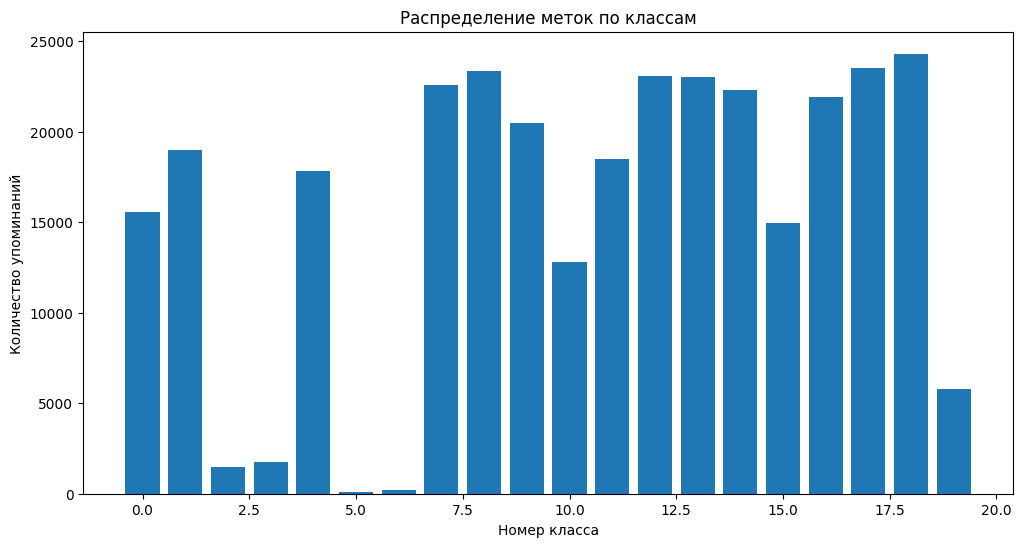

In [9]:
df['labels'] = df['labels'].apply(lambda x: list(map(int, x.split())))
num_classes = len(df['labels'][0])
print(f"Количество классов: {num_classes}")

# Распределение меток
label_counts = [0] * num_classes
for labels in df['labels']:
    for i, val in enumerate(labels):
        label_counts[i] += val

plt.figure(figsize=(12, 6))
plt.bar(range(num_classes), label_counts)
plt.title('Распределение меток по классам')
plt.xlabel('Номер класса')
plt.ylabel('Количество упоминаний')
plt.show()

In [10]:
# доля каждого класса в датасете 
label_percentages = [count / len(df) * 100 for count in label_counts]
print("\nПроцентаж (%):")
for i, perc in enumerate(label_percentages):
    print(f"Label {i}: {perc:.2f}%")


Процентаж (%):
Label 0: 52.70%
Label 1: 64.19%
Label 2: 5.04%
Label 3: 6.01%
Label 4: 60.24%
Label 5: 0.33%
Label 6: 0.70%
Label 7: 76.28%
Label 8: 78.95%
Label 9: 69.32%
Label 10: 43.33%
Label 11: 62.60%
Label 12: 78.03%
Label 13: 77.78%
Label 14: 75.41%
Label 15: 50.48%
Label 16: 74.18%
Label 17: 79.56%
Label 18: 82.18%
Label 19: 19.50%


Text(0, 0.5, 'Частота')

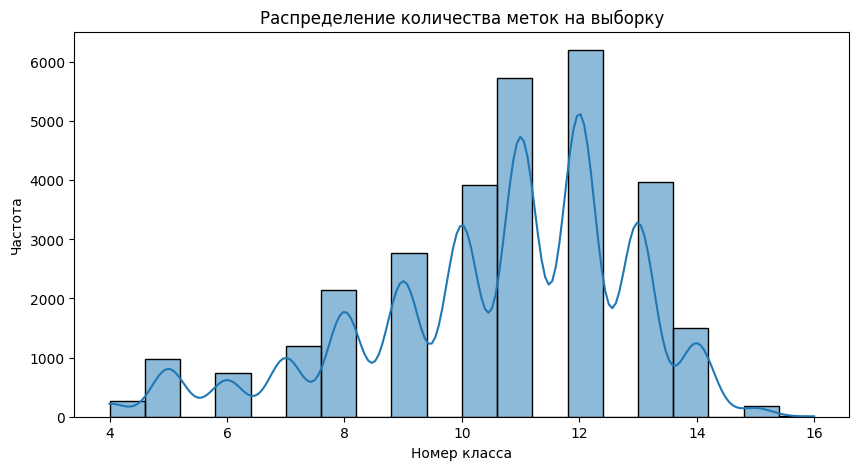

In [11]:
# гистограмма распределения каждого класса 
df['num_labels'] = df['labels'].apply(sum)
plt.figure(figsize=(10, 5))
sns.histplot(df['num_labels'], bins=20, kde=True)
plt.title('Распределение количества меток на выборку')
plt.xlabel('Номер класса')
plt.ylabel('Частота')

In [12]:
# Кардинальность и плотность меток
label_cardinality = df['num_labels'].mean()  # Среднее количество меток на один пример
label_density = label_cardinality / num_classes  # Доля меток от общего числа классов
print(f"\nКардинальность меток: {label_cardinality:.2f}")
print(f"Плотность меток: {label_density:.4f}")


Кардинальность меток: 10.57
Плотность меток: 0.5284


Text(0.5, 1.0, 'Корреляция между метками')

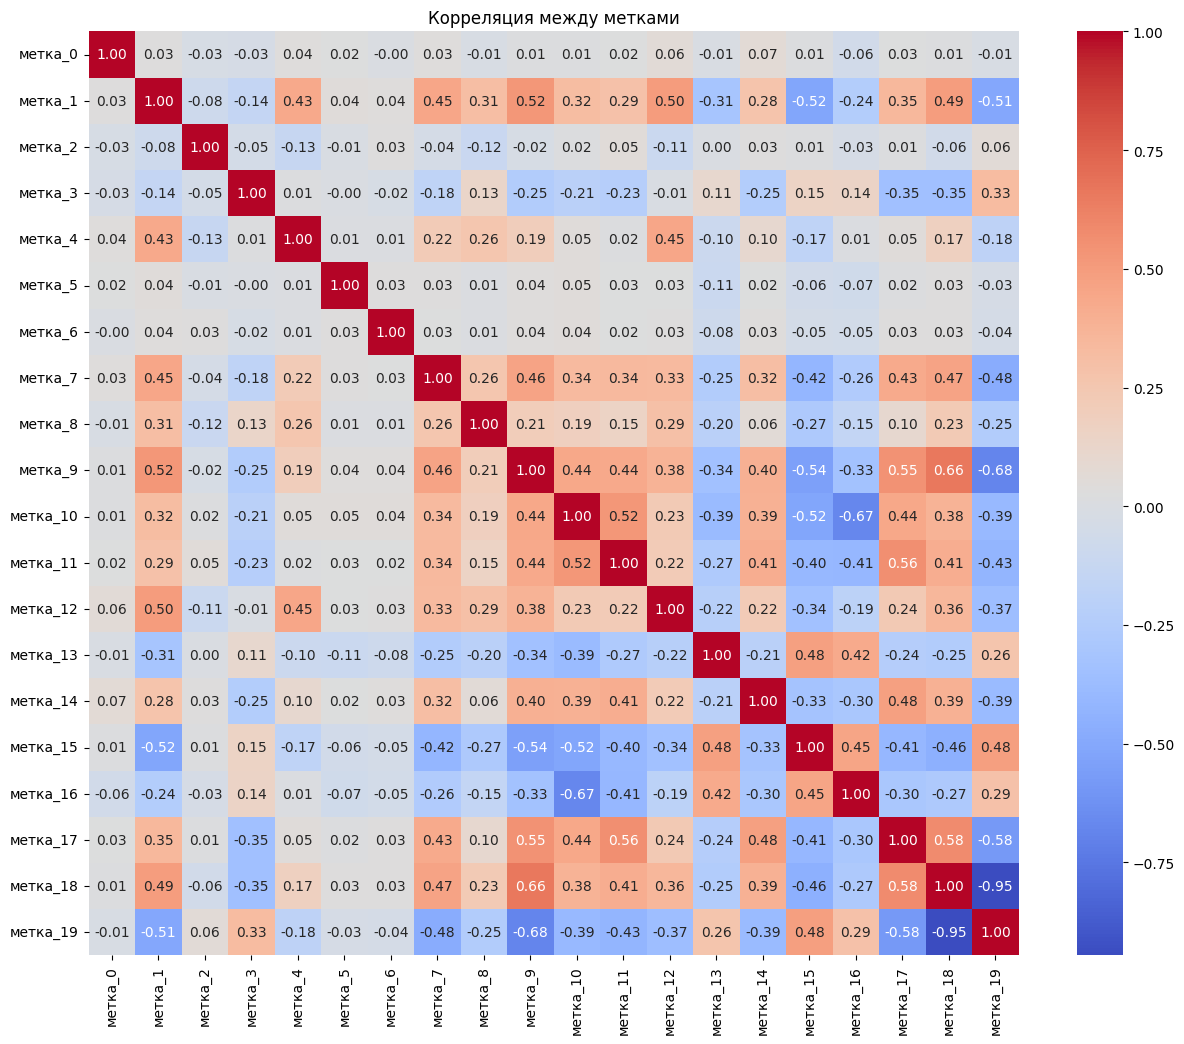

In [13]:
labels_df = pd.DataFrame(df['labels'].tolist(), columns=[f'метка_{i}' for i in range(num_classes)])
corr_matrix = labels_df.corr()
plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Корреляция между метками')

In [14]:
# Находит и выводит самые частые комбинации меток в датасете.
df['labels_str'] = df['labels'].apply(lambda x: ' '.join(map(str, x)))
label_combinations = df['labels_str'].value_counts()
print("\nTop 10 комбинации:")
print(label_combinations.head(10))
print(f"Уникальные комбинации: {len(label_combinations)}")


Top 10 комбинации:
1 1 0 0 1 0 0 1 1 1 1 1 1 0 1 0 0 1 1 0    1053
1 1 0 0 1 0 0 1 1 1 1 1 1 1 1 0 0 1 1 0     742
0 1 0 0 1 0 0 1 1 1 1 1 1 0 1 0 0 1 1 0     727
1 1 0 0 1 0 0 1 1 1 1 1 1 1 1 0 1 1 1 0     510
0 1 0 0 1 0 0 1 1 1 1 1 1 1 1 0 1 1 1 0     477
1 1 0 0 0 0 0 1 1 1 1 1 1 0 1 0 0 1 1 0     442
0 1 0 0 1 0 0 1 1 1 1 1 1 1 1 0 0 1 1 0     422
0 1 0 0 1 0 0 1 1 1 0 1 1 1 1 0 1 1 1 0     420
1 1 0 0 1 0 0 1 1 1 0 1 1 1 1 0 1 1 1 0     352
0 1 0 0 0 0 0 1 1 1 1 1 1 0 1 0 0 1 1 0     348
Name: labels_str, dtype: int64
Уникальные комбинации: 3540



Статистика по длине текста:
Мин. (символов): 1, Макс. (символов): 4081
Мин. (слов): 1, Макс. (слов): 694


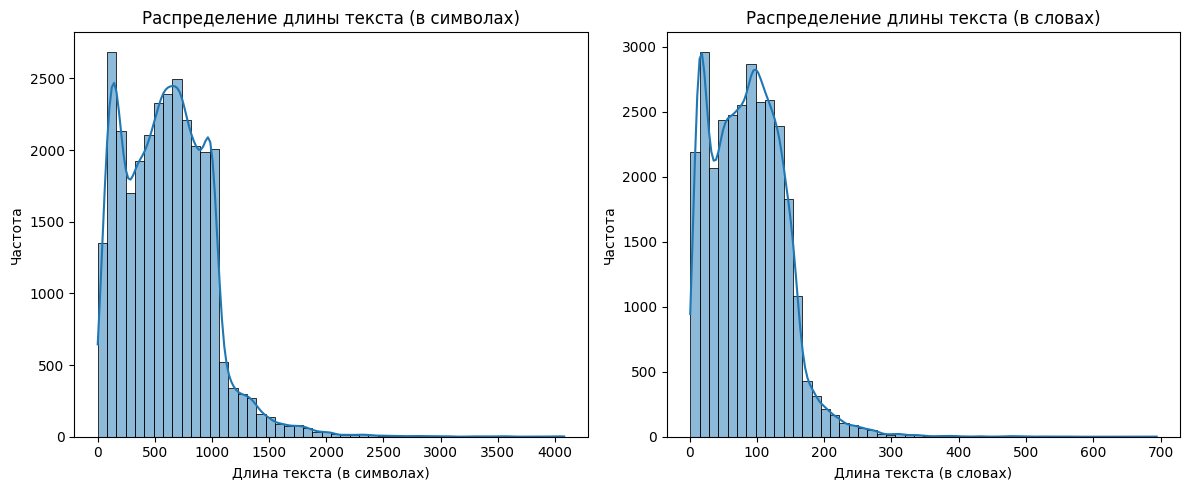

In [15]:
# Анализируем длину текста
df['text_length_chars'] = df['text'].apply(len)  # Длина текста в символах
df['text_length_words'] = df['text'].apply(lambda x: len(x.split()))  # Длина текста в словах
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(df['text_length_chars'], bins=50, kde=True)
plt.title('Распределение длины текста (в символах)')
plt.xlabel('Длина текста (в символах)')  
plt.ylabel('Частота')  # Frequency

plt.subplot(1, 2, 2)
sns.histplot(df['text_length_words'], bins=50, kde=True)
plt.title('Распределение длины текста (в словах)')  
plt.xlabel('Длина текста (в словах)')
plt.ylabel('Частота')

plt.tight_layout()

print(f"\nСтатистика по длине текста:")  # Text Length Stats
print(f"Мин. (символов): {df['text_length_chars'].min()}, Макс. (символов): {df['text_length_chars'].max()}")  
print(f"Мин. (слов): {df['text_length_words'].min()}, Макс. (слов): {df['text_length_words'].max()}") 

In [16]:
# Мне же мало примеров - надо больше 
print("\nТекст и метки")
for i in range(5):
    print(f"Text {i}: {df['text'][i]}")
    print(f"Labels: {df['labels'][i]}\n")


Текст и метки
Text 0: 15 января
Детская развлекательная программа
15-00 бесплатно
❗️
@
cafeotdyh
Кафе "Отдых"
📍
Запись обязательно +73472228532
Labels: [1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1]

Text 1: 13 и 14 августа
Выходные в Меге
https://t.me/megaufa_official
Мегапарк
Labels: [0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1]

Text 2: Йокнапатофа
Постановка Театр им. Маяковского
Билеты от 500 до 2000 р.
Labels: [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1]

Text 3: Впервые в Уфе танцевальная терапия в группе с практикующим психологом
Тема встречи: «Отношения. Доверие. Контакт»
Приходите, если:
🔸
вы хотите наладить или поисследовать свои отношения с
-  телом
- собой
- близким человеком
- работой
- деньгами
🔸
не можете разрешить или забыть какую-то  ситуацию, связанную с отношениями
🔸
не умеете доверять или делегировать
🔸
тяжело вступаете в контакт
Задать вопрос психологу курса
и записаться можно здесь:
@LeontevaKsenia
Дата
: 26 января
Вр

In [17]:
# Дубликаты чеееек
duplicate_texts = df[df.duplicated('text', keep=False)]
print(f"\nКоличество дублирующих текстов: {len(duplicate_texts)}")
if len(duplicate_texts) > 0:
    inconsistent_duplicates = duplicate_texts.groupby('text')['labels_str'].nunique()
    print(f"Количество дубликатов с разными метками: {len(inconsistent_duplicates[inconsistent_duplicates > 1])}")


Количество дублирующих текстов: 4046
Количество дубликатов с разными метками: 487


In [18]:
top_combination = label_combinations.index[0]
print(f"\nПримеры для большинства общих комбинаций меток '{top_combination}':")
samples = df[df['labels_str'] == top_combination].sample(2, random_state=42)
for _, row in samples.iterrows():
    print(f"Текст: {row['text']}\n")


Примеры для большинства общих комбинаций меток '1 1 0 0 1 0 0 1 1 1 1 1 1 0 1 0 0 1 1 0':
Текст: ФЕСТИВАЛЬ ПОХОДНОГО ТУРИЗМА
18 мая 2024 года, с 11:00 до 18:00
г. Пятигорск | Парк Цветник
Пройдет он в рамках Всероссийского туристического слёта «Маёвка». Гостей фестиваля научат правильно устанавливать туристические палатки и вязать узлы, познакомят с основами скалолазания и игры на гитаре, пригласят пройти «По следам княжны Мери» и расскажут о том, как вести собственный блог о путешествиях. В ближайшую субботу, 18 мая, фестиваль стартует в парке Цветник.
Торжественное открытие большого туристического праздника запланировано на 11:00. В программе фестиваля – мастер-классы для детей и взрослых, конкурсы, квесты, игры, выступление эстрадно-духового оркестра «Машук Бэнд» и концерт бардовской песни от творческого объединения «Шестое чувство».
Фестиваль продлится до 18:00. На площадках Цветника в течение всего дня будет не только весело и интересно, но также познавательно и полезно.
Так, сот

# **Выводы по быстрому EDA**

- метки распределены неравномерно (чек график выше), следовательно, можем наблюдать несбалансированность классов 
- в среднем на каждой строчке около 10 меток
- есть дубликаты, причем их дофигаааа, надо это держать в голове
- с длиной текстов я просто игрался, но довольно интересно буду держать в голове
- в тексте много мусора как по мне, 5000 тэгов смайликов и взякой фигни, практически ни один текст не несет смысловой нагрузки одним словом - спам/реклама
- А так, мне не нравится этот датасет... с ругательными словами было бы интересней)

# **Блок_2**

# **ALARM - все буду нещадно тырить с семинаров**
Проанализировать, какие очистки текста необходимы под разные способы токенизации и задания эмбеддингов для этой задачи:
- (1) tf-idf + любая нейронная сеть;
- (2) w2v + любая нейронная сеть; 
- (3) встроенный эмбеддинг в нейросетевое решение на свёрточных сетях; 
- (4) встроенный эмбеддинг в нейросетевое решение на рекуррентных сетях; 
- (5) эмбеддер + решение на bert-like моделях (любой вид).
### Создать пайплайны очистки текста и очистить (1.5 балла). ###


Тк все по сути надо делать в 3 пункте...то я запишу ***?!?!?!?рассуждения??!!?!?!*** 

Поэтому все делаем машинально и ничего не придумываем

Нейросеть я потом подберу тк я ленивый, мне и это писать лениво...но я возьму себя в руки, я что тряпка?!!??!

## **Блок_2.0**

***секретная китайская методика - стыринг все из 6 семинара***

Здесь будет референс из 6 семинара мб допилинный, мб нет

In [19]:
# Оригинал, откуда я буду все тырить 
# сделаем какой-то стандратный препроцессинг (он очень сильно зависит от анализа данных, но мы тут с вами не данные анализировать собрались...)
# def preprocess_text(text, method='lemmatize'):
#     # приводим весь текст к нижнему регистру 
#     text = text.lower()
#     # замена всего некиррилического на пробелы
#     text = re.sub(r'[^а-яё\s]', ' ', text)
#     # могли появиться повторные пробелы - удаляем их
#     text = re.sub(r'\s+', ' ', text).strip()
#     # токенизация (разбиение на слова)
#     tokens = text.split()
#     # лемматизация или стемматизация
#     if method == 'lemmatize':
#         tokens = [morph.parse(token)[0].normal_form for token in tokens]
#     elif method == 'stem':
#         tokens = [stemmer.stem(token) for token in tokens]
#     # удаление коротких слов и стоп слов
#     tokens = [token for token in tokens if token not in stop_words and len(token) > 2]
#     return ' '.join(tokens)

## **Блок_2.1**
**tf-idf + любая нейронная сеть**

## ***Пишем кратко, четко и понятно (или нет)***

**tf-idf** - это статистический метод, который определяет важность слова в документе, учитывая его частоту в данном документе (TF) и редкость его во всём корпусе текстов (IDF). Таким образом, слова, часто встречающиеся в одном документе, но редкие в остальных, получают высокий вес

## **Блоки: Очистка/Токинизация/Особенности**
### 1. **Очистка текста**

Цель — убрать шум, сохранить значимую информацию для частотного анализа:

* Удаление пунктуации (если не несёт смысловой нагрузки) там чет было по типу ////////////////
* Приведение к нижнему регистру (база)
* Удаление спецсимволов, HTML-тегов (интернет ван лав)
* Удаление чисел (если не важны по задаче) (ну или номер телефона)/буду импровизировать 
* Удаление стоп-слов (опционально: зависит от задачи) 
* Лемматизация или стемминг (для уменьшения размерности векторов), но будем юзать лемматизацию, как показала практика все-таки стемминг тк пайморфи2 сломан и уже сил нет с ним возиться 

### 2. **Токенизация**

Подходит простая токенизация на слова

* split() или nltk.word_tokenize()
* Возможны n-граммы (bi- или tri-граммы), но с ругательными словами было бы реально веселей, а тут какая-то сплошная реклама...

### 3. **Особенности при использовании tf-idf с нейронной сетью**

* Если реально читать, тот бред, что я пишу, то насчет токинизации, то она должна быть на уроне слов или символов
* этот способ чекает частотность
* и тут реально надо запариться над очисткой датасета
* пупупу - это читают? 

In [20]:
nltk.download('stopwords')
stop_words = set(stopwords.words('russian'))
stemmer = SnowballStemmer('russian')

def preprocess_text_tf_idf(text):
    text = text.lower() # приводим весь текст к нижнему регистру 

    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Убираем ссылки
    text = re.sub(r'\s+', ' ', text).strip()  # # могли появиться повторные пробелы - удаляем их

    text = re.sub(r'\+?\d{1,3}[-.\s]?\(?\d{1,4}\)?[-.\s]?\d{1,4}[-.\s]?\d{1,4}', '', text).strip() # сомнительно, но пойдет, это убрать номер телефона 

    
    text = re.sub(r'[^\w\s]', '', text)  # пунктуация
    text = re.sub(r'\d+', '', text)  # числа
    words = text.split()
    words = [stemmer.stem(word) for word in words if word not in stop_words]
    return ' '.join(words)


df['text_tf_idf'] = df['text'].apply(preprocess_text_tf_idf) # это надо приминить к датасету, нооооооооо я обычно делаю в самом коде пупупу, но на всякий случай сделал 

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## **Блок_2.2**
**w2v + любая нейронная сеть**

w2v — это алгоритм для преобразования слов в векторы фиксированной длины, которые отражают их семантическое значение

### 1. **Очистка текста**

Цель — сохранить семантически значимые слова для обучения или применения w2v:

* Приведение к нижнему регистру
* Удаление пунктуации и спецсимволов
* Удаление HTML, юзернеймов, URL — всё, что не несёт семантики
* Удаление стоп-слов — **опционально** (можно оставить, т.к. W2V учитывает контекст)
* **Лемматизация** предпочтительна (стемминг хуже влияет на качество эмбеддингов)
* Удаление редких/шумных слов 

### 2. **Токенизация**

* Простая токенизация на слова 
* Используются **списки токенов** 

### 3. **Особенности при использовании Word2Vec с нейронной сетью**

* Каждое слово - это вектор фиксированной размерности 
* Последовательности слов - матрицы
* думаю, все что я написал выше, это важно


### OFFTOP да, я писал про лематизацию, но я на эту модель не ставлю, поэтому стемминг 

In [21]:
def preprocess_text_w2v(text):
    text = text.lower() # Приведение к нижнему регистру
    text = re.sub(r'[^\w\s]', '', text) # Удаление пунктуации и спецсимволов
    text = re.sub(r'[^a-zA-Zа-яА-Я0-9\s]', '', text) # добивка к пунктуации и спецсимволам мб лишняя

    text = re.sub(r'@\w+', '', text) # Удаление юзернеймов

    text = re.sub(r'https?://\S+|www\.\S+', '', text) # Удаление URL

    text = re.sub(r'\s+', ' ', text).strip() # Удаление лишних пробелов

    text = re.sub(r'\d+', '', text) # удаление чисел 

    text = re.sub(r'\+?\d{1,3}[-.\s]?\(?\d{1,4}\)?[-.\s]?\d{1,4}[-.\s]?\d{1,4}', '', text).strip() # сомнительно, но пойдет, это убрать номер телефона 
    
    words = text.split()
    words = [stemmer.stem(word) for word in words if word not in stop_words]
    return ' '.join(words)

df['text_w2v'] = df['text'].apply(preprocess_text_w2v)

## **Блок_2.3**
**встроенный эмбеддинг в нейросетевое решение на свёрточных сетях**

### 1. **Очистка текста**

* Приведение к нижнему регистру # база 
* Удаление пунктуации и спецсимволов
* Удаление HTML-тегов, URL, emoji (если не важны по задаче)
* Стоп-слова: **обычно оставляют** — нейросеть сама учится их игнорировать
* Лемматизация — **необязательна**, так как сеть сама может уловить форму слова
  
### 2. **Особенности при использовании встроенного эмбеддинга + CNN**

* Он преобразует входную последовательность индексов в матрицу
* Затем применяются **свёртки** по оси слов — выявление локальных паттернов те в простонародье (n-грамм)
* CNN хорошо ловит фразы, устойчивые выражения - ну по крайней мере должна
* Слов порядок значение имеет - @ мастер Йода
* Можно не так сильно чистить текст в отличии от 1 пункта 

In [22]:
def preprocess_text_cnn(text):
    text = text.lower() # это база
    text = re.sub(r'https?://\S+|www\.\S+', '', text) # Удаление URL
    text = re.sub(r'[^\w\s]', '', text) 
    text = re.sub(r'[^a-zA-Zа-яА-Я0-9\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text 

df['text_cnn'] = df['text'].apply(preprocess_text_cnn)

## **Блок_2.4**
**встроенный эмбеддинг в нейросетевое решение на рекуррентных сетях**

### 1. **Очистка текста**

Цель — минимально очистить текст 

* Приведение к **нижнему регистру**
* Удаление **пунктуации, спецсимволов, HTML, URL** с этим оооооочень осторожно надо быть 
* **Стоп-слова обычно оставляют** — RNN может извлекать зависимости, хоть что-то хорошее 
* **Лемматизация — опциональна** 
* Эмодзи, числительные — по задаче (могут быть значимыми, а могут и нет) 

### 2. **Особенности при использовании встроенного эмбеддинга + RNN**

* Сохраняется **порядок слов** — важное отличие от CNN
* важное, я уже написал, если обобщить, то мягкая очистка 

In [23]:
def preprocess_text_rnn(text):
    text = text.lower() # это база
    text = re.sub(r'https?://\S+|www\.\S+', '', text) # Удаление URL
    text = re.sub(r'[^\w\s]', '', text) 
    text = re.sub(r'[^a-zA-Zа-яА-Я0-9\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text 

df['text_cnn'] = df['text'].apply(preprocess_text_rnn)

## **Блок_2.5**
**эмбеддер + решение на bert-like моделях (любой вид)**

### 1. **Очистка текста**

Минимальна — трансформеры обучаются на "грязных" данных:

* Приведение к нижнему регистру — **не нужно**, если юзать токенизатор
* Не удалять пунктуацию, стоп-слова, числа — **важны для контекста**
* Удаление HTML-тегов, URL — по необходимости
* **Никакой лемматизации/стемминга** — повредит входу
* Текст должен быть максимально "естественным"

### 2. **Токенизация**

* Используется **встроенный токенизатор модели** (BertTokenizer, AutoTokenizer)
* Автоматически добавляются служебные токены, маски и attention mask

### 3. **Особенности при использовании BERT-like эмбеддеров**

* Текст  эмбеддинги токенов через pre-trained модель (BERT и подобные)
* Выходы:
* Требует много памяти и времени на обучение/инференс
* Поддерживает **маскирование** и **внимание** — хорошо справляется с контекстом



In [24]:
def preprocess_text_bert(text): # тут практически ничего не нужно 
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text 

df['text_bert'] = df['text'].apply(preprocess_text_bert)

# **Блок_3** (тут будет ну прям очень много блоков (6) Буду делать небольшие блоки по 1 примеру тк логичней пилить более соревновательную часть, а не мучать себя 

# **Важно** если у не смогу победить лематизацию, а точнее pymorphy2 (тк его сломали сволочи), то придется юзать стемминг, скорее качество упадет, но это будет работать

Поделить данные на трейн-валидацию, обучить все модели из п.2. Снабдить обучение моделей графиками отрисовки лосей и метрик, шедулерами, свитч лосей (метрик), сохранение лучшей модели, ранней остановкой, вормапом

Буду в основном юзать структуру кода с первого соревнования Kaggle, ествественно все подправлю и все такое, каждый блок будет с нуля...тк мне так будет удобней запускать в тетрадке Юпитера

Модели, которые я хочу использовать https://huggingface.co/s-nlp/russian_toxicity_classifier (я это не использовал :( тк это к сожалению на вектор из предсказаний не смог сделать, а точнее натянуть сову на глобус, хотя долго и упорно старался)

## **Блок_3.0** (делешка на трейн и валидацию) ну и дубликаты убираем, в любом случае это будет лучше, чем не убирать + это все обычно в коде, так что выносить не вижу смысла, это есть буквально в каждой моей модели) 

## **Блок_3.1** tf-idf + любая нейронная сеть

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



Epoch 1/50
------------------------------


Train Loss: 0.3664 | Val Loss: 0.2797 | Val F1 (macro): 0.7302 | Best Threshold: 0.38 | LR: 0.001000
Epoch completed in 15.00 sec.

Epoch 2/50
------------------------------


Train Loss: 0.2553 | Val Loss: 0.2521 | Val F1 (macro): 0.7566 | Best Threshold: 0.30 | LR: 0.001000
Epoch completed in 6.11 sec.

Epoch 3/50
------------------------------


Train Loss: 0.2128 | Val Loss: 0.2389 | Val F1 (macro): 0.7910 | Best Threshold: 0.27 | LR: 0.001000
Epoch completed in 6.15 sec.

Epoch 4/50
------------------------------


Train Loss: 0.1826 | Val Loss: 0.2389 | Val F1 (macro): 0.8032 | Best Threshold: 0.38 | LR: 0.001000
Epoch completed in 6.06 sec.

Epoch 5/50
------------------------------


Train Loss: 0.1579 | Val Loss: 0.2399 | Val F1 (macro): 0.8121 | Best Threshold: 0.34 | LR: 0.001000
Epoch completed in 6.11 sec.

Epoch 6/50
------------------------------


Train Loss: 0.1366 | Val Loss: 0.2515 | Val F1 (macro): 0.8168 | Best Threshold: 0.15 | LR: 0.001000
Epoch completed in 6.35 sec.

Epoch 7/50
------------------------------


Train Loss: 0.1191 | Val Loss: 0.2619 | Val F1 (macro): 0.8204 | Best Threshold: 0.30 | LR: 0.001000
Epoch completed in 6.13 sec.

Epoch 8/50
------------------------------


Train Loss: 0.0972 | Val Loss: 0.2839 | Val F1 (macro): 0.8343 | Best Threshold: 0.34 | LR: 0.000500
Epoch completed in 6.12 sec.

Epoch 9/50
------------------------------


Train Loss: 0.0831 | Val Loss: 0.3056 | Val F1 (macro): 0.8327 | Best Threshold: 0.28 | LR: 0.000500
Epoch completed in 3.96 sec.

Epoch 10/50
------------------------------


Train Loss: 0.0750 | Val Loss: 0.3272 | Val F1 (macro): 0.8361 | Best Threshold: 0.29 | LR: 0.000500
Epoch completed in 6.05 sec.

Epoch 11/50
------------------------------


Train Loss: 0.0642 | Val Loss: 0.3541 | Val F1 (macro): 0.8347 | Best Threshold: 0.24 | LR: 0.000250
Epoch completed in 3.96 sec.

Epoch 12/50
------------------------------


Train Loss: 0.0588 | Val Loss: 0.3668 | Val F1 (macro): 0.8376 | Best Threshold: 0.23 | LR: 0.000250
Epoch completed in 6.05 sec.

Epoch 13/50
------------------------------


Train Loss: 0.0545 | Val Loss: 0.3853 | Val F1 (macro): 0.8376 | Best Threshold: 0.25 | LR: 0.000250
Epoch completed in 3.95 sec.

Epoch 14/50
------------------------------


Train Loss: 0.0504 | Val Loss: 0.3995 | Val F1 (macro): 0.8359 | Best Threshold: 0.31 | LR: 0.000125
Epoch completed in 4.00 sec.

Epoch 15/50
------------------------------


Train Loss: 0.0477 | Val Loss: 0.4070 | Val F1 (macro): 0.8361 | Best Threshold: 0.33 | LR: 0.000125
⏹️ Early stopping triggered


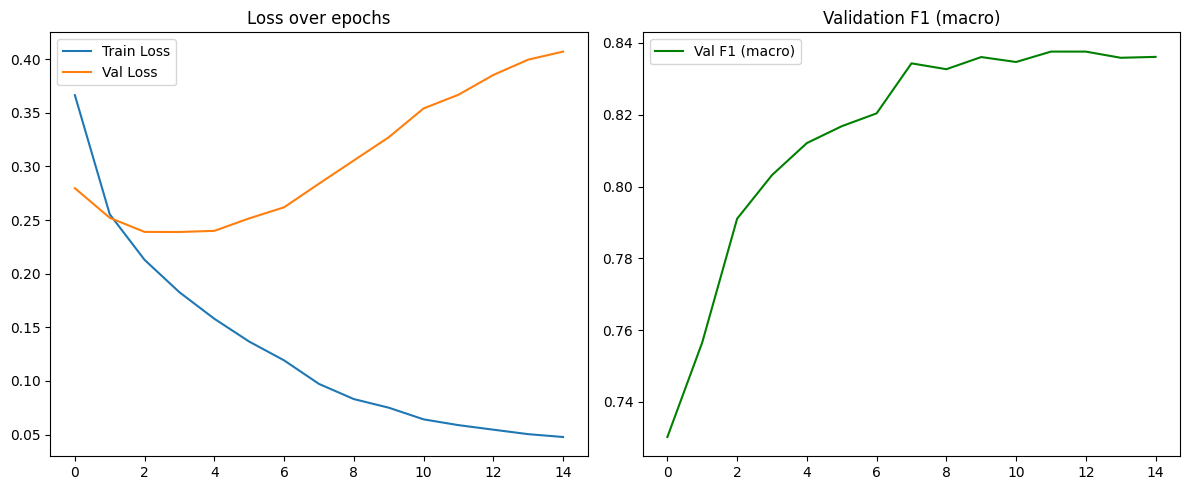


Best Validation F1 (macro): 0.8376 achieved with threshold: 0.23
Test predictions saved to Text_tf_idf.csv
      id                                   labels
0  29568  0 1 0 0 1 0 0 1 1 1 0 1 1 1 1 1 1 1 1 0
1  29569  0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 1
2  29570  0 1 0 0 1 0 0 1 0 1 0 0 1 1 1 0 1 1 1 0
3  29571  0 1 0 0 0 0 0 1 1 1 0 0 1 0 0 0 1 1 1 0
4  29572  1 0 0 0 1 0 0 0 1 0 0 0 1 1 1 1 1 0 0 1
(7392, 2)


In [25]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import copy
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import csv
import time
import random
from tqdm import tqdm


def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

nltk.download('stopwords')
STOP_WORDS = set(stopwords.words('russian'))
STEMMER = SnowballStemmer('russian')

def preprocess_text_tf_idf(text: str) -> str:
    text = text.lower()  # Приводим весь текст к нижнему регистру
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Убираем ссылки
    text = re.sub(r'\s+', ' ', text).strip()             # Убираем лишние пробелы
    text = re.sub(
        r'\+?\d{1,3}[-.\s]?\(?\d{1,4}\)?[-.\s]?\d{1,4}[-.\s]?\d{1,4}', '', text
    ).strip()  # Убираем номера телефонов
    text = re.sub(r'[^\w\s]', '', text)                   # Убираем знаки препинания
    text = re.sub(r'\d+', '', text)                       # Убираем цифры
    words = text.split()
    words = [STEMMER.stem(word) for word in words if word not in STOP_WORDS]
    return ' '.join(words)

df['labels'] = df['labels'].apply(lambda x: " ".join(map(str, x)) if isinstance(x, list) else x)
df.drop_duplicates(subset=['text', 'labels'], inplace=True)

def process_labels(x):
    if isinstance(x, (list, tuple)):
        return list(map(int, x))
    elif isinstance(x, str):
        return list(map(int, x.strip().split()))
    else:
        raise ValueError("Непредвиденный тип для labels")

df['label_vector'] = df['labels'].apply(process_labels)
target_columns = [f'label_{i}' for i in range(len(df['label_vector'].iloc[0]))]
df[target_columns] = pd.DataFrame(df['label_vector'].tolist(), index=df.index)

tf_idf_vectorizer = TfidfVectorizer(max_features=10000)
X_tf_idf = tf_idf_vectorizer.fit_transform(df['text'].apply(preprocess_text_tf_idf))
y = df[target_columns]

X_train, X_val, y_train, y_val = train_test_split(X_tf_idf, y, test_size=0.2, random_state=42)

class TfIdfDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X.toarray(), dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32)

    def __len__(self) -> int:
        return len(self.X)

    def __getitem__(self, idx: int):
        return self.X[idx], self.y[idx]

train_dataset = TfIdfDataset(X_train, y_train)
val_dataset = TfIdfDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

class MLPClassifier(nn.Module):
    def __init__(self, input_dim: int, output_dim: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, output_dim),
            nn.Sigmoid()
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MLPClassifier(X_tf_idf.shape[1], y.shape[1]).to(device)

def train_model(model: nn.Module,
                train_loader: DataLoader,
                val_loader: DataLoader,
                criterion,
                optimizer,
                scheduler=None,
                num_epochs: int = 50,
                model_path: str = 'best_model.pt'):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_f1 = 0.0
    best_threshold = 0.5  
    patience_counter = 0

    train_losses, val_losses, val_f1s = [], [], []

    def get_best_threshold(predictions, labels):
        best_f1_score = 0.0
        best_thresh = 0.5
        for thresh in np.arange(0.1, 0.91, 0.01):
            preds_binarized = (predictions > thresh).astype(int)
            score = f1_score(labels, preds_binarized, average='macro')
            if score > best_f1_score:
                best_f1_score = score
                best_thresh = thresh
        return best_thresh, best_f1_score

    for epoch in range(num_epochs):
        start_time = time.time()
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 30)
        model.train()
        running_loss = 0.0
        for inputs, targets in tqdm(train_loader, desc="Training", leave=False):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_loss_epoch = running_loss / len(train_loader)
        train_losses.append(train_loss_epoch)
        model.eval()
        val_loss = 0.0
        all_preds, all_labels = [], []
        with torch.no_grad():
            for inputs, targets in tqdm(val_loader, desc="Validation", leave=False):
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
                all_preds.append(outputs.cpu().numpy())
                all_labels.append(targets.cpu().numpy())
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        all_preds = np.vstack(all_preds)
        all_labels = np.vstack(all_labels)

        epoch_threshold, epoch_f1 = get_best_threshold(all_preds, all_labels)
        val_f1s.append(epoch_f1)

        current_lr = optimizer.param_groups[0]['lr']
        print(f"Train Loss: {train_loss_epoch:.4f} | Val Loss: {val_loss:.4f} | "
              f"Val F1 (macro): {epoch_f1:.4f} | Best Threshold: {epoch_threshold:.2f} | LR: {current_lr:.6f}")
        if scheduler:
            scheduler.step(val_loss)

        if epoch_f1 > best_f1:
            best_f1 = epoch_f1
            best_threshold = epoch_threshold
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save({'model_state_dict': model.state_dict(), 'threshold': best_threshold}, model_path)
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= 3:
                print("⏹️ Early stopping triggered")
                break

        elapsed = time.time() - start_time
        print(f"Epoch completed in {elapsed:.2f} sec.")

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.legend()
    plt.title("Loss over epochs")
    plt.subplot(1, 2, 2)
    plt.plot(val_f1s, label='Val F1 (macro)', color='green')
    plt.legend()
    plt.title("Validation F1 (macro)")
    plt.tight_layout()
    plt.show()

    print(f"\nBest Validation F1 (macro): {best_f1:.4f} achieved with threshold: {best_threshold:.2f}")
    model.load_state_dict(best_model_wts)
    return model, best_threshold

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

model, best_threshold = train_model(model, train_loader, val_loader, criterion,
                                    optimizer, scheduler=scheduler,
                                    num_epochs=50, model_path='mlp_tfidf_best.pt')


test_file = "data_for_kaggle/test.csv"
test_df = pd.read_csv(test_file, encoding='utf-8')

test_df['text_tf_idf'] = test_df['text'].apply(preprocess_text_tf_idf)
X_test = tf_idf_vectorizer.transform(test_df['text_tf_idf'])

model.eval()
with torch.no_grad():
    X_test_tensor = torch.tensor(X_test.toarray(), dtype=torch.float32).to(device)
    outputs_test = model(X_test_tensor)
    preds_test = (outputs_test > best_threshold).float().cpu().numpy()

results = []
for idx, preds in zip(test_df['id'], preds_test):
    pred_str = " ".join(str(int(x)) for x in preds)
    results.append((idx, pred_str))

output_file = "Text_tf_idf.csv"

with open(output_file, 'w', newline='', encoding='utf-8') as f:
    writer = csv.writer(f)
    writer.writerow(["ID", "labels"])
    writer.writerows(results)
print(f"Test predictions saved to {output_file}")

with open(output_file, 'r', newline='', encoding='utf-8') as f:
    reader = csv.reader(f)
    header = next(reader)
    header = [h.lower() if h.lower() in ['id', 'labels'] else h for h in header]
    rows = [[row[0].split('.')[0]] + row[1:] for row in reader]

sorted_rows = sorted(rows, key=lambda x: int(x[0]))

with open(output_file, 'w', newline='', encoding='utf-8') as f:
    writer = csv.writer(f)
    writer.writerow(header)
    writer.writerows(sorted_rows)

data = pd.read_csv(output_file)
print(data.head())
print(data.shape)


## **Блок_3.2**  w2v + любая нейронная сеть

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



Epoch 1/50
------------------------------


Train Loss: 0.3592 | Val Loss: 0.3056 | Val F1 (macro): 0.7292 | Best Threshold: 0.29 | LR: 0.001000
Epoch completed in 2.71 sec.

Epoch 2/50
------------------------------


Train Loss: 0.3109 | Val Loss: 0.2980 | Val F1 (macro): 0.7342 | Best Threshold: 0.27 | LR: 0.001000
Epoch completed in 2.69 sec.

Epoch 3/50
------------------------------


Train Loss: 0.2977 | Val Loss: 0.2870 | Val F1 (macro): 0.7404 | Best Threshold: 0.33 | LR: 0.001000
Epoch completed in 2.67 sec.

Epoch 4/50
------------------------------


Train Loss: 0.2894 | Val Loss: 0.2781 | Val F1 (macro): 0.7463 | Best Threshold: 0.36 | LR: 0.001000
Epoch completed in 2.70 sec.

Epoch 5/50
------------------------------


Train Loss: 0.2813 | Val Loss: 0.2725 | Val F1 (macro): 0.7502 | Best Threshold: 0.35 | LR: 0.001000
Epoch completed in 2.74 sec.

Epoch 6/50
------------------------------


Train Loss: 0.2765 | Val Loss: 0.2709 | Val F1 (macro): 0.7487 | Best Threshold: 0.38 | LR: 0.001000
Epoch completed in 2.67 sec.

Epoch 7/50
------------------------------


Train Loss: 0.2717 | Val Loss: 0.2657 | Val F1 (macro): 0.7665 | Best Threshold: 0.27 | LR: 0.001000
Epoch completed in 2.70 sec.

Epoch 8/50
------------------------------


Train Loss: 0.2673 | Val Loss: 0.2607 | Val F1 (macro): 0.7749 | Best Threshold: 0.33 | LR: 0.001000
Epoch completed in 2.73 sec.

Epoch 9/50
------------------------------


Train Loss: 0.2627 | Val Loss: 0.2617 | Val F1 (macro): 0.7782 | Best Threshold: 0.34 | LR: 0.001000
Epoch completed in 2.77 sec.

Epoch 10/50
------------------------------


Train Loss: 0.2586 | Val Loss: 0.2556 | Val F1 (macro): 0.7766 | Best Threshold: 0.31 | LR: 0.001000
Epoch completed in 2.71 sec.

Epoch 11/50
------------------------------


Train Loss: 0.2556 | Val Loss: 0.2627 | Val F1 (macro): 0.7755 | Best Threshold: 0.31 | LR: 0.001000
Epoch completed in 2.73 sec.

Epoch 12/50
------------------------------


Train Loss: 0.2541 | Val Loss: 0.2543 | Val F1 (macro): 0.7816 | Best Threshold: 0.33 | LR: 0.001000
Epoch completed in 2.83 sec.

Epoch 13/50
------------------------------


Train Loss: 0.2501 | Val Loss: 0.2499 | Val F1 (macro): 0.7823 | Best Threshold: 0.35 | LR: 0.001000
Epoch completed in 2.83 sec.

Epoch 14/50
------------------------------


Train Loss: 0.2474 | Val Loss: 0.2495 | Val F1 (macro): 0.7839 | Best Threshold: 0.39 | LR: 0.001000
Epoch completed in 2.80 sec.

Epoch 15/50
------------------------------


Train Loss: 0.2440 | Val Loss: 0.2481 | Val F1 (macro): 0.7928 | Best Threshold: 0.34 | LR: 0.001000
Epoch completed in 2.77 sec.

Epoch 16/50
------------------------------


Train Loss: 0.2429 | Val Loss: 0.2488 | Val F1 (macro): 0.7820 | Best Threshold: 0.36 | LR: 0.001000
Epoch completed in 2.74 sec.

Epoch 17/50
------------------------------


Train Loss: 0.2398 | Val Loss: 0.2464 | Val F1 (macro): 0.7826 | Best Threshold: 0.35 | LR: 0.001000
Epoch completed in 2.74 sec.

Epoch 18/50
------------------------------


Train Loss: 0.2379 | Val Loss: 0.2445 | Val F1 (macro): 0.7849 | Best Threshold: 0.31 | LR: 0.001000
⏹️ Early stopping triggered


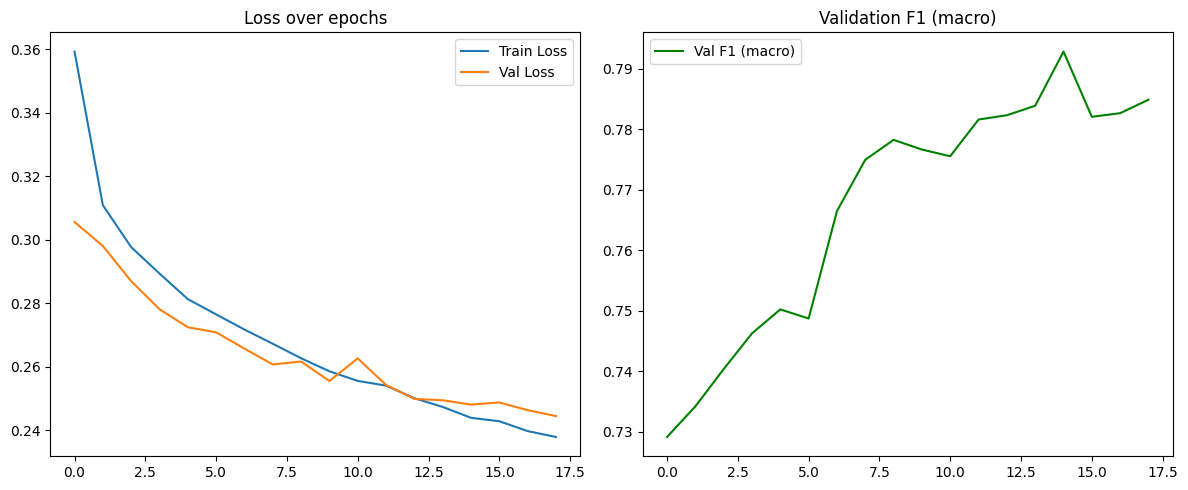


Best Validation F1 (macro): 0.7928 achieved with threshold: 0.34
Test predictions saved to W2v.csv
      id                                   labels
0  29568  1 1 0 0 1 0 0 1 1 1 0 1 1 1 1 0 1 1 1 0
1  29569  0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 1
2  29570  0 1 0 0 1 0 0 1 0 1 1 0 1 1 1 0 1 1 1 0
3  29571  1 1 0 0 1 0 0 1 1 1 0 0 1 1 1 1 1 1 1 0
4  29572  1 0 0 1 1 0 0 1 1 0 0 0 1 1 1 1 1 0 0 1
(7392, 2)


In [26]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import copy
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import csv
import time
import random
from tqdm import tqdm
from gensim.models import Word2Vec

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

nltk.download('stopwords')


stop_words = set(stopwords.words('russian'))
stemmer = SnowballStemmer('russian')

def preprocess_text_w2v(text):
    text = text.lower()  # Приведение к нижнему регистру
    text = re.sub(r'[^\w\s]', '', text)  # Удаление пунктуации и спецсимволов
    text = re.sub(r'[^a-zA-Zа-яА-Я0-9\s]', '', text)  # Дополнительное удаление лишних символов (может быть избыточно)
    text = re.sub(r'@\w+', '', text)  # Удаление юзернеймов
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Удаление URL
    text = re.sub(r'\s+', ' ', text).strip()  # Удаление лишних пробелов
    text = re.sub(r'\d+', '', text)  # Удаление чисел 
    text = re.sub(r'\+?\d{1,3}[-.\s]?\(?\d{1,4}\)?[-.\s]?\d{1,4}[-.\s]?\d{1,4}', '', text).strip()  # Удаление номеров телефонов
    words = text.split()
    words = [stemmer.stem(word) for word in words if word not in stop_words]
    return ' '.join(words)


df = pd.read_csv("data_for_kaggle/train.csv", encoding='utf-8')
df.drop_duplicates(subset=['text', 'labels'], inplace=True)


df['label_vector'] = df['labels'].apply(lambda x: list(map(int, x.strip().split())))
df['text_w2v'] = df['text'].apply(preprocess_text_w2v)
target_columns = [f'label_{i}' for i in range(len(df['label_vector'].iloc[0]))]
df[target_columns] = pd.DataFrame(df['label_vector'].tolist(), index=df.index)

documents = [text.split() for text in df['text_w2v']]
w2v_model = Word2Vec(documents, vector_size=300, window=5, min_count=1, workers=4)

def get_mean_w2v(text, model, vector_size=300):
    words = text.split()
    vectors = []
    for word in words:
        if word in model.wv:
            vectors.append(model.wv[word])
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(vector_size)

X_w2v = np.array([get_mean_w2v(text, w2v_model, vector_size=300) for text in df['text_w2v']])
y = df[target_columns]

X_train, X_val, y_train, y_val = train_test_split(X_w2v, y, test_size=0.2, random_state=42)

class Word2VecDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = Word2VecDataset(X_train, y_train)
val_dataset = Word2VecDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

class MLPClassifier(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, output_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MLPClassifier(300, y.shape[1]).to(device)

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler=None, num_epochs=50, model_path='best_model.pt'):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_f1 = 0.0
    best_threshold = 0.5  
    patience_counter = 0

    train_losses, val_losses, val_f1s = [], [], []

    def get_best_threshold(predictions, labels):
        best_f1_score = 0.0
        best_thresh = 0.5
        for thresh in np.arange(0.1, 0.91, 0.01):
            preds_binarized = (predictions > thresh).astype(int)
            score = f1_score(labels, preds_binarized, average='macro')
            if score > best_f1_score:
                best_f1_score = score
                best_thresh = thresh
        return best_thresh, best_f1_score

    for epoch in range(num_epochs):
        start_time = time.time()
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 30)
        model.train()
        running_loss = 0.0
        for inputs, targets in tqdm(train_loader, desc="Training", leave=False):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_loss_epoch = running_loss / len(train_loader)
        train_losses.append(train_loss_epoch)

        model.eval()
        val_loss = 0.0
        all_preds, all_labels = [], []
        with torch.no_grad():
            for inputs, targets in tqdm(val_loader, desc="Validation", leave=False):
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
                all_preds.append(outputs.cpu().numpy())
                all_labels.append(targets.cpu().numpy())
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        all_preds = np.vstack(all_preds)
        all_labels = np.vstack(all_labels)

        epoch_threshold, epoch_f1 = get_best_threshold(all_preds, all_labels)
        val_f1s.append(epoch_f1)

        current_lr = optimizer.param_groups[0]['lr']
        print(f"Train Loss: {train_loss_epoch:.4f} | Val Loss: {val_loss:.4f} | "
              f"Val F1 (macro): {epoch_f1:.4f} | Best Threshold: {epoch_threshold:.2f} | LR: {current_lr:.6f}")
        if scheduler:
            scheduler.step(val_loss)

        if epoch_f1 > best_f1:
            best_f1 = epoch_f1
            best_threshold = epoch_threshold
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save({'model_state_dict': model.state_dict(), 'threshold': best_threshold}, model_path)
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= 3:
                print("⏹️ Early stopping triggered")
                break

        elapsed = time.time() - start_time
        print(f"Epoch completed in {elapsed:.2f} sec.")

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.legend()
    plt.title("Loss over epochs")

    plt.subplot(1, 2, 2)
    plt.plot(val_f1s, label='Val F1 (macro)', color='green')
    plt.legend()
    plt.title("Validation F1 (macro)")

    plt.tight_layout()
    plt.show()

    print(f"\nBest Validation F1 (macro): {best_f1:.4f} achieved with threshold: {best_threshold:.2f}")
    model.load_state_dict(best_model_wts)
    return model, best_threshold

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

model, best_threshold = train_model(model, train_loader, val_loader, criterion,
                                    optimizer, scheduler=scheduler,
                                    num_epochs=50, model_path='mlp_w2v_best.pt')

test_file = "data_for_kaggle/test.csv"  
test_df = pd.read_csv(test_file, encoding='utf-8')
test_df['text_w2v'] = test_df['text'].apply(preprocess_text_w2v)
X_test = np.array([get_mean_w2v(text, w2v_model, vector_size=300) for text in test_df['text_w2v']])

model.eval()
with torch.no_grad():
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    outputs_test = model(X_test_tensor)
    preds_test = (outputs_test > best_threshold).float().cpu().numpy()

results = []
for idx, preds in zip(test_df['id'], preds_test):
    pred_str = " ".join(str(int(x)) for x in preds)
    results.append((idx, pred_str))

output_file = "W2v.csv"

with open(output_file, 'w', newline='', encoding='utf-8') as f:
    writer = csv.writer(f)
    writer.writerow(["ID", "labels"])
    writer.writerows(results)
print(f"Test predictions saved to {output_file}")

with open(output_file, 'r', newline='', encoding='utf-8') as f:
    reader = csv.reader(f)
    header = next(reader)
    header = [h.lower() if h.lower() in ['id', 'labels'] else h for h in header]
    rows = [[row[0].split('.')[0]] + row[1:] for row in reader]

sorted_rows = sorted(rows, key=lambda x: int(x[0]))
with open(output_file, 'w', newline='', encoding='utf-8') as f:
    writer = csv.writer(f)
    writer.writerow(header)
    writer.writerows(sorted_rows)

data = pd.read_csv(output_file)
print(data.head())
print(data.shape)


## **Блок_3.3** встроенный эмбеддинг в нейросетевое решение на свёрточных сетях; 

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Vocab size: 118256

Epoch 1/50
------------------------------


Train Loss: 0.4224 | Val Loss: 0.3246 | Val F1 (macro): 0.7028 | Best Threshold: 0.44 | LR: 0.001000
Epoch completed in 27.17 sec.

Epoch 2/50
------------------------------


Train Loss: 0.3396 | Val Loss: 0.2963 | Val F1 (macro): 0.7198 | Best Threshold: 0.43 | LR: 0.001000
Epoch completed in 16.37 sec.

Epoch 3/50
------------------------------


Train Loss: 0.3127 | Val Loss: 0.2824 | Val F1 (macro): 0.7267 | Best Threshold: 0.41 | LR: 0.001000
Epoch completed in 16.02 sec.

Epoch 4/50
------------------------------


Train Loss: 0.2927 | Val Loss: 0.2706 | Val F1 (macro): 0.7424 | Best Threshold: 0.38 | LR: 0.001000
Epoch completed in 16.20 sec.

Epoch 5/50
------------------------------


Train Loss: 0.2768 | Val Loss: 0.2671 | Val F1 (macro): 0.7511 | Best Threshold: 0.36 | LR: 0.001000
Epoch completed in 16.17 sec.

Epoch 6/50
------------------------------


Train Loss: 0.2624 | Val Loss: 0.2630 | Val F1 (macro): 0.7518 | Best Threshold: 0.38 | LR: 0.001000
Epoch completed in 16.20 sec.

Epoch 7/50
------------------------------


Train Loss: 0.2469 | Val Loss: 0.2610 | Val F1 (macro): 0.7564 | Best Threshold: 0.35 | LR: 0.001000
Epoch completed in 16.47 sec.

Epoch 8/50
------------------------------


Train Loss: 0.2366 | Val Loss: 0.2602 | Val F1 (macro): 0.7559 | Best Threshold: 0.31 | LR: 0.001000
Epoch completed in 6.83 sec.

Epoch 9/50
------------------------------


Train Loss: 0.2258 | Val Loss: 0.2628 | Val F1 (macro): 0.7601 | Best Threshold: 0.44 | LR: 0.001000
Epoch completed in 16.15 sec.

Epoch 10/50
------------------------------


Train Loss: 0.2156 | Val Loss: 0.2639 | Val F1 (macro): 0.7648 | Best Threshold: 0.36 | LR: 0.001000
Epoch completed in 16.22 sec.

Epoch 11/50
------------------------------


Train Loss: 0.2057 | Val Loss: 0.2750 | Val F1 (macro): 0.7659 | Best Threshold: 0.33 | LR: 0.001000
Epoch completed in 16.17 sec.

Epoch 12/50
------------------------------


Train Loss: 0.1928 | Val Loss: 0.2767 | Val F1 (macro): 0.7652 | Best Threshold: 0.43 | LR: 0.000500
Epoch completed in 6.79 sec.

Epoch 13/50
------------------------------


Train Loss: 0.1853 | Val Loss: 0.2847 | Val F1 (macro): 0.7661 | Best Threshold: 0.43 | LR: 0.000500
Epoch completed in 16.33 sec.

Epoch 14/50
------------------------------


Train Loss: 0.1787 | Val Loss: 0.2922 | Val F1 (macro): 0.7657 | Best Threshold: 0.41 | LR: 0.000500
Epoch completed in 6.80 sec.

Epoch 15/50
------------------------------


Train Loss: 0.1720 | Val Loss: 0.2945 | Val F1 (macro): 0.7697 | Best Threshold: 0.31 | LR: 0.000250
Epoch completed in 16.17 sec.

Epoch 16/50
------------------------------


Train Loss: 0.1678 | Val Loss: 0.3002 | Val F1 (macro): 0.7676 | Best Threshold: 0.30 | LR: 0.000250
Epoch completed in 6.74 sec.

Epoch 17/50
------------------------------


Train Loss: 0.1640 | Val Loss: 0.3037 | Val F1 (macro): 0.7711 | Best Threshold: 0.31 | LR: 0.000250
Epoch completed in 16.04 sec.

Epoch 18/50
------------------------------


Train Loss: 0.1605 | Val Loss: 0.3059 | Val F1 (macro): 0.7703 | Best Threshold: 0.30 | LR: 0.000125
Epoch completed in 6.71 sec.

Epoch 19/50
------------------------------


Train Loss: 0.1585 | Val Loss: 0.3095 | Val F1 (macro): 0.7704 | Best Threshold: 0.33 | LR: 0.000125
Epoch completed in 6.71 sec.

Epoch 20/50
------------------------------


Train Loss: 0.1579 | Val Loss: 0.3123 | Val F1 (macro): 0.7710 | Best Threshold: 0.34 | LR: 0.000125
⏹️ Early stopping triggered


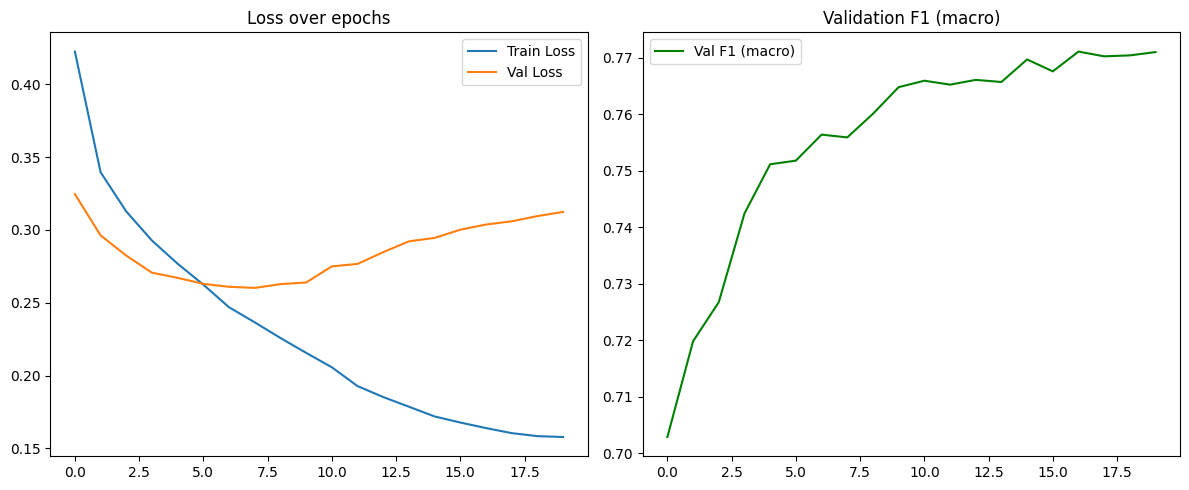


Best Validation F1 (macro): 0.7711 achieved with threshold: 0.31
Test predictions saved to Cnn.csv
      id                                   labels
0  29568  1 1 0 0 1 0 0 1 1 1 0 1 1 1 1 1 1 1 1 0
1  29569  1 0 1 1 0 0 0 0 1 0 0 0 0 1 0 1 1 0 0 1
2  29570  0 1 0 0 1 0 0 1 0 1 0 0 1 1 1 0 1 1 1 0
3  29571  1 1 0 0 1 0 0 1 1 1 0 0 1 1 1 1 1 1 1 0
4  29572  1 1 0 0 1 0 0 1 1 1 0 0 1 1 1 0 1 1 1 0
(7392, 2)


In [27]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import copy
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import csv
import time
import random
from tqdm import tqdm


def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

nltk.download('stopwords')
STOP_WORDS = set(stopwords.words('russian'))
STEMMER = SnowballStemmer('russian')


def preprocess_text_cnn(text):
    text = text.lower()  # Приведение к нижнему регистру
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Удаление URL
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'[^a-zA-Zа-яА-Я0-9\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df = pd.read_csv("data_for_kaggle/train.csv", encoding='utf-8')
df.drop_duplicates(subset=['text', 'labels'], inplace=True)
df['text_cnn'] = df['text'].apply(preprocess_text_cnn)

df['label_vector'] = df['labels'].apply(lambda x: list(map(int, x.strip().split())))
target_columns = ['label_' + str(i) for i in range(len(df['label_vector'].iloc[0]))]
df[target_columns] = pd.DataFrame(df['label_vector'].tolist(), index=df.index)

texts = df['text_cnn'].tolist()

tokenized_texts = [text.split() for text in texts]

word2idx = {}
for tokens in tokenized_texts:
    for token in tokens:
        if token not in word2idx:
            word2idx[token] = len(word2idx) + 1

vocab_size = len(word2idx) + 1
print("Vocab size:", vocab_size)

def text_to_sequence(text, word2idx, max_len=100):
    tokens = text.split()
    seq = [word2idx.get(token, 0) for token in tokens]
    if len(seq) < max_len:
        seq += [0] * (max_len - len(seq))
    else:
        seq = seq[:max_len]
    return seq

max_len = 100
df['seq'] = df['text_cnn'].apply(lambda x: text_to_sequence(x, word2idx, max_len))


X_sequences = np.array(df['seq'].tolist())
y = df[target_columns]

X_train, X_val, y_train, y_val = train_test_split(X_sequences, y, test_size=0.2, random_state=42)

class CNNTextDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.long) 
        self.y = torch.tensor(y.values, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = CNNTextDataset(X_train, y_train)
val_dataset = CNNTextDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


class CNNTextClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_classes):
        super(CNNTextClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.conv = nn.Conv1d(in_channels=embed_dim, out_channels=100, kernel_size=3)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(100, num_classes)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.embedding(x)        
        x = x.transpose(1, 2)          
        x = self.conv(x)            
        x = torch.relu(x)
        x = torch.max(x, dim=2)[0]    
        x = self.dropout(x)
        x = self.fc(x)
        x = self.sigmoid(x)
        return x

embed_dim = 300  
num_classes = y.shape[1]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNNTextClassifier(vocab_size, embed_dim, num_classes).to(device)


def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler=None,
                num_epochs=50, model_path='best_model.pt'):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_f1 = 0.0
    best_threshold = 0.5
    patience_counter = 0

    train_losses, val_losses, val_f1s = [], [], []

    def get_best_threshold(predictions, labels):
        best_f1_score = 0.0
        best_thresh = 0.5
        for thresh in np.arange(0.1, 0.91, 0.01):
            preds_binarized = (predictions > thresh).astype(int)
            score = f1_score(labels, preds_binarized, average='macro')
            if score > best_f1_score:
                best_f1_score = score
                best_thresh = thresh
        return best_thresh, best_f1_score

    for epoch in range(num_epochs):
        start_time = time.time()
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 30)
        model.train()
        running_loss = 0.0
        for inputs, targets in tqdm(train_loader, desc="Training", leave=False):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_loss_epoch = running_loss / len(train_loader)
        train_losses.append(train_loss_epoch)

        model.eval()
        val_loss = 0.0
        all_preds, all_labels = [], []
        with torch.no_grad():
            for inputs, targets in tqdm(val_loader, desc="Validation", leave=False):
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
                all_preds.append(outputs.cpu().numpy())
                all_labels.append(targets.cpu().numpy())
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        all_preds = np.vstack(all_preds)
        all_labels = np.vstack(all_labels)

        epoch_threshold, epoch_f1 = get_best_threshold(all_preds, all_labels)
        val_f1s.append(epoch_f1)

        current_lr = optimizer.param_groups[0]['lr']
        print(f"Train Loss: {train_loss_epoch:.4f} | Val Loss: {val_loss:.4f} | "
              f"Val F1 (macro): {epoch_f1:.4f} | Best Threshold: {epoch_threshold:.2f} | LR: {current_lr:.6f}")
        if scheduler:
            scheduler.step(val_loss)

        if epoch_f1 > best_f1:
            best_f1 = epoch_f1
            best_threshold = epoch_threshold
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save({'model_state_dict': model.state_dict(), 'threshold': best_threshold}, model_path)
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= 3:
                print("⏹️ Early stopping triggered")
                break

        elapsed = time.time() - start_time
        print(f"Epoch completed in {elapsed:.2f} sec.")

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.legend()
    plt.title("Loss over epochs")
    plt.subplot(1, 2, 2)
    plt.plot(val_f1s, label='Val F1 (macro)', color='green')
    plt.legend()
    plt.title("Validation F1 (macro)")
    plt.tight_layout()
    plt.show()

    print(f"\nBest Validation F1 (macro): {best_f1:.4f} achieved with threshold: {best_threshold:.2f}")
    model.load_state_dict(best_model_wts)
    return model, best_threshold

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

model, best_threshold = train_model(model, train_loader, val_loader, criterion,
                                    optimizer, scheduler=scheduler,
                                    num_epochs=50, model_path='mlp_cnn_best.pt')


test_file = "data_for_kaggle/test.csv"  
test_df = pd.read_csv(test_file, encoding='utf-8')


test_df['text_cnn'] = test_df['text'].apply(preprocess_text_cnn)
test_df['seq'] = test_df['text_cnn'].apply(lambda x: text_to_sequence(x, word2idx, max_len))
X_test = np.array(test_df['seq'].tolist())

model.eval()
with torch.no_grad():
    X_test_tensor = torch.tensor(X_test, dtype=torch.long).to(device)
    outputs_test = model(X_test_tensor)
    preds_test = (outputs_test > best_threshold).float().cpu().numpy()

results = []
for idx, preds in zip(test_df['id'], preds_test):
    pred_str = " ".join(str(int(x)) for x in preds)
    results.append((idx, pred_str))

output_file = "Cnn.csv"
with open(output_file, 'w', newline='', encoding='utf-8') as f:
    writer = csv.writer(f)
    writer.writerow(["ID", "labels"])
    writer.writerows(results)
print(f"Test predictions saved to {output_file}")

with open(output_file, 'r', newline='', encoding='utf-8') as f:
    reader = csv.reader(f)
    header = next(reader)
    header = [h.lower() if h.lower() in ['id', 'labels'] else h for h in header]
    rows = [[row[0].split('.')[0]] + row[1:] for row in reader]

sorted_rows = sorted(rows, key=lambda x: int(x[0]))
with open(output_file, 'w', newline='', encoding='utf-8') as f:
    writer = csv.writer(f)
    writer.writerow(header)
    writer.writerows(sorted_rows)

data = pd.read_csv(output_file)
print(data.head())
print(data.shape)


## **Блок_3.4** встроенный эмбеддинг в нейросетевое решение на рекуррентных сетях; 

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Vocab size: 118256

Epoch 1/50
------------------------------


Train Loss: 0.3602 | Val Loss: 0.3144 | Val F1 (macro): 0.7201 | Best Threshold: 0.40 | LR: 0.001000
Epoch completed in 18.57 sec.

Epoch 2/50
------------------------------


Train Loss: 0.2831 | Val Loss: 0.2737 | Val F1 (macro): 0.7312 | Best Threshold: 0.38 | LR: 0.001000
Epoch completed in 16.40 sec.

Epoch 3/50
------------------------------


Train Loss: 0.2473 | Val Loss: 0.2543 | Val F1 (macro): 0.7482 | Best Threshold: 0.21 | LR: 0.001000
Epoch completed in 16.28 sec.

Epoch 4/50
------------------------------


Train Loss: 0.2187 | Val Loss: 0.2445 | Val F1 (macro): 0.7577 | Best Threshold: 0.25 | LR: 0.001000
Epoch completed in 16.50 sec.

Epoch 5/50
------------------------------


Train Loss: 0.1928 | Val Loss: 0.2420 | Val F1 (macro): 0.7615 | Best Threshold: 0.18 | LR: 0.001000
Epoch completed in 16.33 sec.

Epoch 6/50
------------------------------


Train Loss: 0.1705 | Val Loss: 0.2402 | Val F1 (macro): 0.7724 | Best Threshold: 0.16 | LR: 0.001000
Epoch completed in 16.33 sec.

Epoch 7/50
------------------------------


Train Loss: 0.1492 | Val Loss: 0.2425 | Val F1 (macro): 0.7790 | Best Threshold: 0.25 | LR: 0.001000
Epoch completed in 16.37 sec.

Epoch 8/50
------------------------------


Train Loss: 0.1300 | Val Loss: 0.2468 | Val F1 (macro): 0.7842 | Best Threshold: 0.23 | LR: 0.001000
Epoch completed in 16.27 sec.

Epoch 9/50
------------------------------


Train Loss: 0.1123 | Val Loss: 0.2543 | Val F1 (macro): 0.7912 | Best Threshold: 0.17 | LR: 0.001000
Epoch completed in 16.52 sec.

Epoch 10/50
------------------------------


Train Loss: 0.0936 | Val Loss: 0.2580 | Val F1 (macro): 0.7936 | Best Threshold: 0.22 | LR: 0.000500
Epoch completed in 16.04 sec.

Epoch 11/50
------------------------------


Train Loss: 0.0815 | Val Loss: 0.2664 | Val F1 (macro): 0.7958 | Best Threshold: 0.28 | LR: 0.000500
Epoch completed in 16.58 sec.

Epoch 12/50
------------------------------


Train Loss: 0.0724 | Val Loss: 0.2758 | Val F1 (macro): 0.7969 | Best Threshold: 0.14 | LR: 0.000500
Epoch completed in 16.39 sec.

Epoch 13/50
------------------------------


Train Loss: 0.0632 | Val Loss: 0.2815 | Val F1 (macro): 0.8010 | Best Threshold: 0.15 | LR: 0.000250
Epoch completed in 16.48 sec.

Epoch 14/50
------------------------------


Train Loss: 0.0576 | Val Loss: 0.2897 | Val F1 (macro): 0.8021 | Best Threshold: 0.17 | LR: 0.000250
Epoch completed in 16.11 sec.

Epoch 15/50
------------------------------


Train Loss: 0.0533 | Val Loss: 0.2964 | Val F1 (macro): 0.8020 | Best Threshold: 0.16 | LR: 0.000250
Epoch completed in 7.03 sec.

Epoch 16/50
------------------------------


Train Loss: 0.0488 | Val Loss: 0.3009 | Val F1 (macro): 0.8018 | Best Threshold: 0.20 | LR: 0.000125
Epoch completed in 6.98 sec.

Epoch 17/50
------------------------------


Train Loss: 0.0458 | Val Loss: 0.3046 | Val F1 (macro): 0.8029 | Best Threshold: 0.22 | LR: 0.000125
Epoch completed in 16.32 sec.

Epoch 18/50
------------------------------


Train Loss: 0.0436 | Val Loss: 0.3098 | Val F1 (macro): 0.8030 | Best Threshold: 0.26 | LR: 0.000125
Epoch completed in 16.42 sec.

Epoch 19/50
------------------------------


Train Loss: 0.0414 | Val Loss: 0.3127 | Val F1 (macro): 0.8035 | Best Threshold: 0.21 | LR: 0.000063
Epoch completed in 16.36 sec.

Epoch 20/50
------------------------------


Train Loss: 0.0401 | Val Loss: 0.3154 | Val F1 (macro): 0.8039 | Best Threshold: 0.21 | LR: 0.000063
Epoch completed in 16.42 sec.

Epoch 21/50
------------------------------


Train Loss: 0.0390 | Val Loss: 0.3185 | Val F1 (macro): 0.8040 | Best Threshold: 0.22 | LR: 0.000063
Epoch completed in 16.64 sec.

Epoch 22/50
------------------------------


Train Loss: 0.0379 | Val Loss: 0.3198 | Val F1 (macro): 0.8040 | Best Threshold: 0.22 | LR: 0.000031
Epoch completed in 16.54 sec.

Epoch 23/50
------------------------------


Train Loss: 0.0372 | Val Loss: 0.3213 | Val F1 (macro): 0.8043 | Best Threshold: 0.22 | LR: 0.000031
Epoch completed in 16.58 sec.

Epoch 24/50
------------------------------


Train Loss: 0.0366 | Val Loss: 0.3228 | Val F1 (macro): 0.8042 | Best Threshold: 0.22 | LR: 0.000031
Epoch completed in 7.10 sec.

Epoch 25/50
------------------------------


Train Loss: 0.0361 | Val Loss: 0.3239 | Val F1 (macro): 0.8041 | Best Threshold: 0.29 | LR: 0.000016
Epoch completed in 7.11 sec.

Epoch 26/50
------------------------------


Train Loss: 0.0357 | Val Loss: 0.3247 | Val F1 (macro): 0.8042 | Best Threshold: 0.29 | LR: 0.000016
⏹️ Early stopping triggered


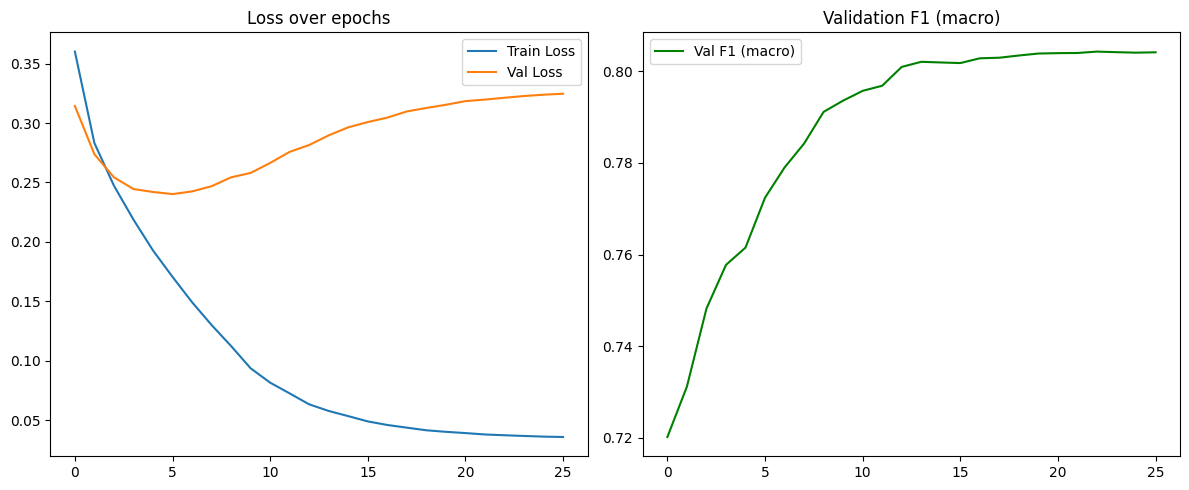


Best Validation F1 (macro): 0.8043 achieved with threshold: 0.22
Test predictions saved to Rnn.csv
      id                                   labels
0  29568  0 1 0 0 1 0 0 1 1 1 0 1 1 1 1 1 1 1 1 0
1  29569  0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 1
2  29570  0 1 0 0 1 0 0 1 0 1 0 0 1 1 1 0 1 1 1 0
3  29571  1 1 0 0 1 0 0 1 1 1 0 1 1 1 1 1 1 1 1 0
4  29572  0 1 0 1 1 0 0 1 1 0 0 0 1 1 0 1 1 0 0 1
(7392, 2)


In [28]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import copy
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import csv
import time
import random
from tqdm import tqdm

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

nltk.download('stopwords')
STOP_WORDS = set(stopwords.words('russian'))
STEMMER = SnowballStemmer('russian')


def preprocess_text_rnn(text):
    text = text.lower()  # Приведение к нижнему регистру
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Удаление URL
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'[^a-zA-Zа-яА-Я0-9\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text


df = pd.read_csv("data_for_kaggle/train.csv", encoding='utf-8')
df.drop_duplicates(subset=['text', 'labels'], inplace=True)

df['text_rnn'] = df['text'].apply(preprocess_text_rnn)


df['label_vector'] = df['labels'].apply(lambda x: list(map(int, x.strip().split())))

target_columns = ['label_' + str(i) for i in range(len(df['label_vector'].iloc[0]))]
df[target_columns] = pd.DataFrame(df['label_vector'].tolist(), index=df.index)


texts = df['text_rnn'].tolist()
tokenized_texts = [text.split() for text in texts]

word2idx = {}
for tokens in tokenized_texts:
    for token in tokens:
        if token not in word2idx:
            word2idx[token] = len(word2idx) + 1
vocab_size = len(word2idx) + 1
print("Vocab size:", vocab_size)

def text_to_sequence(text, word2idx, max_len=100):
    tokens = text.split()
    seq = [word2idx.get(token, 0) for token in tokens]
    if len(seq) < max_len:
        seq += [0] * (max_len - len(seq))
    else:
        seq = seq[:max_len]
    return seq

max_len = 100
df['seq'] = df['text_rnn'].apply(lambda x: text_to_sequence(x, word2idx, max_len))

X_seq = np.array(df['seq'].tolist())
y = df[target_columns]


X_train, X_val, y_train, y_val = train_test_split(X_seq, y, test_size=0.2, random_state=42)


class RNNTextDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.long)
        self.y = torch.tensor(y.values, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = RNNTextDataset(X_train, y_train)
val_dataset = RNNTextDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


class RNNTextClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_layers, num_classes, dropout):
        super(RNNTextClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.fc = nn.Linear(hidden_dim, num_classes)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.embedding(x)
        out, (hn, cn) = self.lstm(x)       
        h_last = hn[-1]                   
        out = self.fc(h_last)             
        out = self.sigmoid(out)
        return out

embed_dim = 300
hidden_dim = 128
num_layers = 1
dropout = 0.5
num_classes = y.shape[1]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RNNTextClassifier(vocab_size, embed_dim, hidden_dim, num_layers, num_classes, dropout).to(device)


def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler=None, num_epochs=50, model_path='best_model.pt'):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_f1 = 0.0
    best_threshold = 0.5
    patience_counter = 0

    train_losses, val_losses, val_f1s = [], [], []

    def get_best_threshold(predictions, labels):
        best_f1_score = 0.0
        best_thresh = 0.5
        for thresh in np.arange(0.1, 0.91, 0.01):
            preds_binarized = (predictions > thresh).astype(int)
            score = f1_score(labels, preds_binarized, average='macro')
            if score > best_f1_score:
                best_f1_score = score
                best_thresh = thresh
        return best_thresh, best_f1_score

    for epoch in range(num_epochs):
        start_time = time.time()
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 30)
        model.train()
        running_loss = 0.0
        for inputs, targets in tqdm(train_loader, desc="Training", leave=False):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_loss_epoch = running_loss / len(train_loader)
        train_losses.append(train_loss_epoch)

        model.eval()
        val_loss = 0.0
        all_preds, all_labels = [], []
        with torch.no_grad():
            for inputs, targets in tqdm(val_loader, desc="Validation", leave=False):
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
                all_preds.append(outputs.cpu().numpy())
                all_labels.append(targets.cpu().numpy())
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        all_preds = np.vstack(all_preds)
        all_labels = np.vstack(all_labels)
        epoch_threshold, epoch_f1 = get_best_threshold(all_preds, all_labels)
        val_f1s.append(epoch_f1)

        current_lr = optimizer.param_groups[0]['lr']
        print(f"Train Loss: {train_loss_epoch:.4f} | Val Loss: {val_loss:.4f} | "
              f"Val F1 (macro): {epoch_f1:.4f} | Best Threshold: {epoch_threshold:.2f} | LR: {current_lr:.6f}")
        if scheduler:
            scheduler.step(val_loss)
        if epoch_f1 > best_f1:
            best_f1 = epoch_f1
            best_threshold = epoch_threshold
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save({'model_state_dict': model.state_dict(), 'threshold': best_threshold}, model_path)
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= 3:
                print("⏹️ Early stopping triggered")
                break
        elapsed = time.time() - start_time
        print(f"Epoch completed in {elapsed:.2f} sec.")
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.legend()
    plt.title("Loss over epochs")
    plt.subplot(1, 2, 2)
    plt.plot(val_f1s, label='Val F1 (macro)', color='green')
    plt.legend()
    plt.title("Validation F1 (macro)")
    plt.tight_layout()
    plt.show()
    
    print(f"\nBest Validation F1 (macro): {best_f1:.4f} achieved with threshold: {best_threshold:.2f}")
    model.load_state_dict(best_model_wts)
    return model, best_threshold

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

model, best_threshold = train_model(model, train_loader, val_loader, criterion,
                                    optimizer, scheduler=scheduler,
                                    num_epochs=50, model_path='mlp_rnn_best.pt')


test_file = "data_for_kaggle/test.csv"
test_df = pd.read_csv(test_file, encoding='utf-8')
test_df['text_rnn'] = test_df['text'].apply(preprocess_text_rnn)
test_df['seq'] = test_df['text_rnn'].apply(lambda x: text_to_sequence(x, word2idx, max_len))
X_test = np.array(test_df['seq'].tolist())

model.eval()
with torch.no_grad():
    X_test_tensor = torch.tensor(X_test, dtype=torch.long).to(device)
    outputs_test = model(X_test_tensor)
    preds_test = (outputs_test > best_threshold).float().cpu().numpy()

results = []
for idx, preds in zip(test_df['id'], preds_test):
    pred_str = " ".join(str(int(x)) for x in preds)
    results.append((idx, pred_str))

output_file = "Rnn.csv"
with open(output_file, 'w', newline='', encoding='utf-8') as f:
    writer = csv.writer(f)
    writer.writerow(["ID", "labels"])
    writer.writerows(results)
print(f"Test predictions saved to {output_file}")

with open(output_file, 'r', newline='', encoding='utf-8') as f:
    reader = csv.reader(f)
    header = next(reader)
    header = [h.lower() if h.lower() in ['id', 'labels'] else h for h in header]
    rows = [[row[0].split('.')[0]] + row[1:] for row in reader]

sorted_rows = sorted(rows, key=lambda x: int(x[0]))
with open(output_file, 'w', newline='', encoding='utf-8') as f:
    writer = csv.writer(f)
    writer.writerow(header)
    writer.writerows(sorted_rows)

data = pd.read_csv(output_file)
print(data.head())
print(data.shape)


## **Блок_3.5** эмбеддер + решение на bert-like моделях (любой вид).

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import copy
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import csv
import random
from tqdm import tqdm
from transformers import AutoTokenizer, BertForSequenceClassification, get_scheduler


def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)


nltk.download('stopwords')
STOP_WORDS = set(stopwords.words('russian'))
STEMMER = SnowballStemmer('russian')


def preprocess_text_bert(text):
    # тут практически ничего не нужно
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text


df = pd.read_csv("data_for_kaggle/train.csv", encoding='utf-8')
df.drop_duplicates(subset=['text', 'labels'], inplace=True)
df['text_bert'] = df['text'].apply(preprocess_text_bert)
df['label_vector'] = df['labels'].apply(lambda x: list(map(int, x.strip().split())))

target_columns = [f'label_{i}' for i in range(len(df['label_vector'].iloc[0]))]
df[target_columns] = pd.DataFrame(df['label_vector'].tolist(), index=df.index)

MODEL_NAME = "DeepPavlov/rubert-base-cased"
NUM_LABELS = len(target_columns)   
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


X_train, X_val, y_train, y_val = train_test_split(
    df['text_bert'].tolist(), 
    df[target_columns],
    test_size=0.2,
    random_state=42
)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)


class BertDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = torch.tensor(labels.values, dtype=torch.float32)
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        encoding = self.tokenizer(
            text, 
            truncation=True, 
            padding='max_length', 
            max_length=self.max_length, 
            return_tensors='pt'
        )
        item = {key: val.squeeze(0) for key, val in encoding.items()}
        item['labels'] = self.labels[idx]
        return item

train_dataset = BertDataset(X_train, y_train, tokenizer)
val_dataset = BertDataset(X_val, y_val, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)


class BERTClassifier(nn.Module):
    def __init__(self, model_name, num_labels):
        super().__init__()
        self.bert = BertForSequenceClassification.from_pretrained(
            model_name,
            num_labels=num_labels,
            ignore_mismatched_sizes=True
        )
        self.bert.config.problem_type = "multi_label_classification"
    
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        return outputs.logits

model = BERTClassifier(MODEL_NAME, NUM_LABELS).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
total_steps = 5 * len(train_loader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

best_f1 = 0.0
best_model_wts = copy.deepcopy(model.state_dict())
best_threshold = 0.5
patience = 2
patience_counter = 0
train_losses, val_losses, val_f1s = [], [], []

def get_best_threshold(predictions, labels):
    best_f1_score = 0.0
    best_thresh = 0.5
    for thresh in np.arange(0.1, 0.91, 0.01):
        preds_binarized = (predictions > thresh).astype(int)
        score = f1_score(labels, preds_binarized, average='macro')
        if score > best_f1_score:
            best_f1_score = score
            best_thresh = thresh
    return best_thresh, best_f1_score

# Цикл обучения и валидации
for epoch in range(5):
    model.train()
    running_loss = 0.0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1} Training"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)
        
        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        lr_scheduler.step()
        running_loss += loss.item()
        
    train_loss_epoch = running_loss / len(train_loader)
    train_losses.append(train_loss_epoch)
    
    model.eval()
    val_loss = 0.0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validation"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            all_preds.append(torch.sigmoid(outputs).cpu().numpy())
            all_labels.append(labels.cpu().numpy())
            
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    all_preds = np.vstack(all_preds)
    all_labels = np.vstack(all_labels)
    epoch_threshold, epoch_f1 = get_best_threshold(all_preds, all_labels)
    val_f1s.append(epoch_f1)
    
    print(f"Epoch {epoch+1} | Train Loss: {train_loss_epoch:.4f} | Val Loss: {val_loss:.4f} | "
          f"Val F1: {epoch_f1:.4f} | Threshold: {epoch_threshold:.2f}")
    
    if epoch_f1 > best_f1:
        best_f1 = epoch_f1
        best_threshold = epoch_threshold
        best_model_wts = copy.deepcopy(model.state_dict())
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered")
            break

print(f"\nBest Validation F1: {best_f1:.4f} achieved with threshold {best_threshold:.2f}")
model.load_state_dict(best_model_wts)


plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.legend()
plt.title("Loss Curve")
plt.subplot(1,2,2)
plt.plot(val_f1s, label="Val F1")
plt.legend()
plt.title("Validation F1")
plt.tight_layout()
plt.show()


test_df = pd.read_csv("data_for_kaggle/test.csv", encoding='utf-8')
test_df['text_bert'] = test_df['text'].apply(preprocess_text_bert)

if "id" in test_df.columns:
    id_col = "id"
elif "ID" in test_df.columns:
    id_col = "ID"
else:
    raise ValueError("No id column found in test data!")


class BertTestDataset(Dataset):
    def __init__(self, texts, tokenizer, max_length=128):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        encoding = self.tokenizer(
            text, truncation=True, padding='max_length', max_length=self.max_length, 
            return_tensors='pt'
        )
        return {key: val.squeeze(0) for key, val in encoding.items()}

test_texts = test_df['text_bert'].tolist()
test_dataset = BertTestDataset(test_texts, tokenizer)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


all_test_preds = []
model.eval()
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Test Inference"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.sigmoid(outputs).cpu().numpy()
        all_test_preds.append(preds)
all_test_preds = np.vstack(all_test_preds)
final_preds = (all_test_preds > best_threshold).astype(int)


results = []
for idx, preds in zip(test_df[id_col], final_preds):
    pred_str = " ".join(str(int(x)) for x in preds)
    results.append((idx, pred_str))

output_file = "DeepPavlov_bert_multilabel_predictions.csv"
with open(output_file, "w", newline="", encoding="utf-8") as f:
    writer = csv.writer(f)
    writer.writerow(["ID", "labels"])
    writer.writerows(results)

print("Test predictions saved to", output_file)


with open(output_file, "r", newline="", encoding="utf-8") as f:
    reader = csv.reader(f)
    header = next(reader)
    header = [h.lower() if h.lower() in ["id", "labels"] else h for h in header]
    rows = [[row[0].split('.')[0]] + row[1:] for row in reader]
sorted_rows = sorted(rows, key=lambda x: int(x[0]))
with open(output_file, "w", newline="", encoding="utf-8") as f:
    writer = csv.writer(f)
    writer.writerow(header)
    writer.writerows(sorted_rows)

df_final = pd.read_csv(output_file)
print(df_final.head())
print(df_final.shape)


Epoch 1 Training:  25%|██▌       | 344/1373 [01:11<03:34,  4.79it/s]

# **Блок_4**

апросить у модели декодер сгенерировать примеры с тем же распределением меток, что и у данных. Обогатить этими данными датасет (добавить хотя бы 1000 наблюдений). Проверить свой лучший пайплайн на улучшение/уменьшение качества модели вместе со сгенерированными данными. Сделать выводы и объяснить результат.

Естественно все будет нещадно тыриться с семинаров 

Генерация синтетических примеров: 100%|██████████| 1000/1000 [02:02<00:00,  8.15it/s]


Размер обогащённого датасета: (28454, 26)
Обучение модели на обогащённых данных...

Epoch 1/50
------------------------------


Train Loss: 0.3724 | Val Loss: 0.2846 | Val F1 (macro): 0.7248 | Best Threshold: 0.34 | LR: 0.001000
Epoch completed in 6.31 sec.

Epoch 2/50
------------------------------


Train Loss: 0.2647 | Val Loss: 0.2531 | Val F1 (macro): 0.7683 | Best Threshold: 0.28 | LR: 0.001000
Epoch completed in 6.33 sec.

Epoch 3/50
------------------------------


Train Loss: 0.2223 | Val Loss: 0.2421 | Val F1 (macro): 0.7832 | Best Threshold: 0.31 | LR: 0.001000
Epoch completed in 6.31 sec.

Epoch 4/50
------------------------------


Train Loss: 0.1914 | Val Loss: 0.2439 | Val F1 (macro): 0.7923 | Best Threshold: 0.24 | LR: 0.001000
Epoch completed in 6.30 sec.

Epoch 5/50
------------------------------


Train Loss: 0.1674 | Val Loss: 0.2436 | Val F1 (macro): 0.8073 | Best Threshold: 0.36 | LR: 0.001000
Epoch completed in 6.35 sec.

Epoch 6/50
------------------------------


Train Loss: 0.1477 | Val Loss: 0.2524 | Val F1 (macro): 0.8110 | Best Threshold: 0.42 | LR: 0.001000
Epoch completed in 6.27 sec.

Epoch 7/50
------------------------------


Train Loss: 0.1231 | Val Loss: 0.2639 | Val F1 (macro): 0.8156 | Best Threshold: 0.35 | LR: 0.000500
Epoch completed in 6.27 sec.

Epoch 8/50
------------------------------


Train Loss: 0.1078 | Val Loss: 0.2779 | Val F1 (macro): 0.8188 | Best Threshold: 0.29 | LR: 0.000500
Epoch completed in 6.39 sec.

Epoch 9/50
------------------------------


Train Loss: 0.0977 | Val Loss: 0.2928 | Val F1 (macro): 0.8235 | Best Threshold: 0.40 | LR: 0.000500
Epoch completed in 6.35 sec.

Epoch 10/50
------------------------------


Train Loss: 0.0868 | Val Loss: 0.3141 | Val F1 (macro): 0.8246 | Best Threshold: 0.42 | LR: 0.000250
Epoch completed in 6.38 sec.

Epoch 11/50
------------------------------


Train Loss: 0.0801 | Val Loss: 0.3340 | Val F1 (macro): 0.8288 | Best Threshold: 0.27 | LR: 0.000250
Epoch completed in 6.37 sec.

Epoch 12/50
------------------------------


Train Loss: 0.0756 | Val Loss: 0.3474 | Val F1 (macro): 0.8305 | Best Threshold: 0.39 | LR: 0.000250
Epoch completed in 6.35 sec.

Epoch 13/50
------------------------------


Train Loss: 0.0702 | Val Loss: 0.3619 | Val F1 (macro): 0.8309 | Best Threshold: 0.33 | LR: 0.000125
Epoch completed in 6.43 sec.

Epoch 14/50
------------------------------


Train Loss: 0.0673 | Val Loss: 0.3688 | Val F1 (macro): 0.8304 | Best Threshold: 0.29 | LR: 0.000125
Epoch completed in 4.16 sec.

Epoch 15/50
------------------------------


Train Loss: 0.0651 | Val Loss: 0.3764 | Val F1 (macro): 0.8304 | Best Threshold: 0.37 | LR: 0.000125
Epoch completed in 4.15 sec.

Epoch 16/50
------------------------------


Train Loss: 0.0621 | Val Loss: 0.3822 | Val F1 (macro): 0.8316 | Best Threshold: 0.36 | LR: 0.000063
Epoch completed in 6.35 sec.

Epoch 17/50
------------------------------


Train Loss: 0.0610 | Val Loss: 0.3917 | Val F1 (macro): 0.8315 | Best Threshold: 0.29 | LR: 0.000063
Epoch completed in 4.13 sec.

Epoch 18/50
------------------------------


Train Loss: 0.0605 | Val Loss: 0.3936 | Val F1 (macro): 0.8313 | Best Threshold: 0.28 | LR: 0.000063
Epoch completed in 4.17 sec.

Epoch 19/50
------------------------------


Train Loss: 0.0594 | Val Loss: 0.3967 | Val F1 (macro): 0.8309 | Best Threshold: 0.28 | LR: 0.000031
⏹️ Early stopping triggered


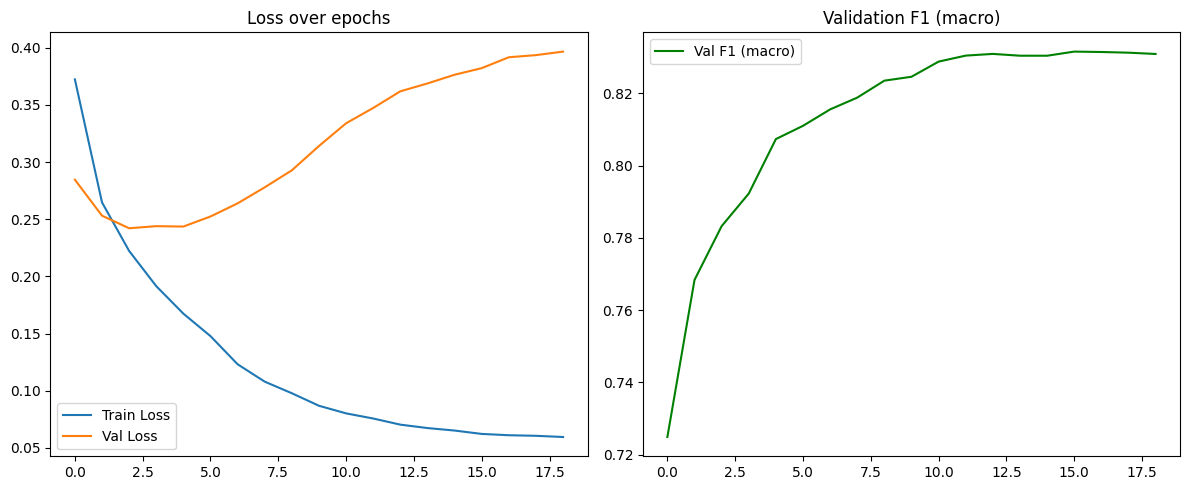


Best Validation F1 (macro): 0.8316 achieved with threshold: 0.36

Сравнение результатов:
Исходные данные: Best F1: 0.8376 с threshold: 0.23
Обогащённые данные: Best F1: 0.8316 с threshold: 0.36

Результат ухудшился после обогащения датасета синтетическими данными.


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import copy
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import csv
import time
import random
from tqdm import tqdm

from transformers import pipeline

def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

nltk.download('stopwords')
STOP_WORDS = set(stopwords.words('russian'))
STEMMER = SnowballStemmer('russian')

def preprocess_text_tf_idf(text: str) -> str:
    text = text.lower()
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  
    text = re.sub(r'\s+', ' ', text).strip()             
    text = re.sub(r'\+?\d{1,3}[-.\s]?\(?\d{1,4}\)?[-.\s]?\d{1,4}[-.\s]?\d{1,4}', '', text).strip()  
    text = re.sub(r'[^\w\s]', '', text)                   
    text = re.sub(r'\d+', '', text)                       
    words = text.split()
    words = [STEMMER.stem(word) for word in words if word not in STOP_WORDS]
    return ' '.join(words)

def process_labels(x):
    if isinstance(x, (list, tuple)):
        return list(map(int, x))
    elif isinstance(x, str):
        return list(map(int, x.strip().split()))
    else:
        raise ValueError("Непредвиденный тип для labels")


def prepare_data(df):
    df['labels'] = df['labels'].apply(lambda x: " ".join(map(str, x)) if isinstance(x, list) else x)
    df.drop_duplicates(subset=['text', 'labels'], inplace=True)
    df['label_vector'] = df['labels'].apply(process_labels)
    target_columns = [f'label_{i}' for i in range(len(df['label_vector'].iloc[0]))]
    df[target_columns] = pd.DataFrame(df['label_vector'].tolist(), index=df.index)
    df['text_tf_idf'] = df['text'].apply(preprocess_text_tf_idf)
    return df, target_columns

df, target_columns = prepare_data(df.copy())
tf_idf_vectorizer = TfidfVectorizer(max_features=10000)
X_tf_idf = tf_idf_vectorizer.fit_transform(df['text_tf_idf'])
y = df[target_columns]

X_train, X_val, y_train, y_val = train_test_split(X_tf_idf, y, test_size=0.2, random_state=42)

class TfIdfDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X.toarray(), dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32)

    def __len__(self) -> int:
        return len(self.X)

    def __getitem__(self, idx: int):
        return self.X[idx], self.y[idx]

train_dataset = TfIdfDataset(X_train, y_train)
val_dataset = TfIdfDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


class MLPClassifier(nn.Module):
    def __init__(self, input_dim: int, output_dim: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, output_dim),
            nn.Sigmoid()
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_original = MLPClassifier(X_tf_idf.shape[1], y.shape[1]).to(device)

def train_model(model: nn.Module,
                train_loader: DataLoader,
                val_loader: DataLoader,
                criterion,
                optimizer,
                scheduler=None,
                num_epochs: int = 50,
                model_path: str = 'best_model.pt'):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_f1 = 0.0
    best_threshold = 0.5  
    patience_counter = 0

    train_losses, val_losses, val_f1s = [], [], []

    def get_best_threshold(predictions, labels):
        best_f1_score = 0.0
        best_thresh = 0.5
        for thresh in np.arange(0.1, 0.91, 0.01):
            preds_binarized = (predictions > thresh).astype(int)
            score = f1_score(labels, preds_binarized, average='macro')
            if score > best_f1_score:
                best_f1_score = score
                best_thresh = thresh
        return best_thresh, best_f1_score

    for epoch in range(num_epochs):
        start_time = time.time()
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 30)
        model.train()
        running_loss = 0.0
        for inputs, targets in tqdm(train_loader, desc="Training", leave=False):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_loss_epoch = running_loss / len(train_loader)
        train_losses.append(train_loss_epoch)

        model.eval()
        val_loss = 0.0
        all_preds, all_labels = [], []
        with torch.no_grad():
            for inputs, targets in tqdm(val_loader, desc="Validation", leave=False):
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
                all_preds.append(outputs.cpu().numpy())
                all_labels.append(targets.cpu().numpy())
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        all_preds = np.vstack(all_preds)
        all_labels = np.vstack(all_labels)

        epoch_threshold, epoch_f1 = get_best_threshold(all_preds, all_labels)
        val_f1s.append(epoch_f1)

        current_lr = optimizer.param_groups[0]['lr']
        print(f"Train Loss: {train_loss_epoch:.4f} | Val Loss: {val_loss:.4f} | "
              f"Val F1 (macro): {epoch_f1:.4f} | Best Threshold: {epoch_threshold:.2f} | LR: {current_lr:.6f}")
        if scheduler:
            scheduler.step(val_loss)

        if epoch_f1 > best_f1:
            best_f1 = epoch_f1
            best_threshold = epoch_threshold
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save({'model_state_dict': model.state_dict(), 'threshold': best_threshold}, model_path)
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= 3:
                print("⏹️ Early stopping triggered")
                break

        elapsed = time.time() - start_time
        print(f"Epoch completed in {elapsed:.2f} sec.")

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.legend()
    plt.title("Loss over epochs")
    plt.subplot(1, 2, 2)
    plt.plot(val_f1s, label='Val F1 (macro)', color='green')
    plt.legend()
    plt.title("Validation F1 (macro)")
    plt.tight_layout()
    plt.show()

    print(f"\nBest Validation F1 (macro): {best_f1:.4f} achieved with threshold: {best_threshold:.2f}")
    model.load_state_dict(best_model_wts)
    return model, best_threshold, best_f1

criterion = nn.BCELoss()
optimizer_original = torch.optim.Adam(model_original.parameters(), lr=1e-3)
scheduler_original = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_original, mode='min', factor=0.5, patience=2)

print("Обучение модели на исходных данных...")
model_original, best_threshold_original, best_f1_original = train_model(model_original, train_loader, val_loader, 
                                                                        criterion, optimizer_original, 
                                                                        scheduler=scheduler_original,
                                                                        num_epochs=50, model_path='best_model_original.pt')

generator = pipeline("text-generation", model="sberbank-ai/rugpt3small_based_on_gpt2", 
                     device=0 if torch.cuda.is_available() else -1)

def generate_text_with_label(label_vector):
    label_str = " ".join(str(int(x)) for x in label_vector)
    prompt = f"Тема меток: {label_str}. Напиши пример текста на русском языке:"
    result = generator(prompt, max_length=50, num_return_sequences=1)
    generated_text = result[0]['generated_text'][len(prompt):].strip()
    return generated_text

def generate_synthetic_examples(num_examples, label_vectors):
    synthetic_texts = []
    synthetic_labels = []
    for i in tqdm(range(num_examples), desc="Генерация синтетических примеров"):
        label_vector = random.choice(label_vectors)
        synthetic_text = generate_text_with_label(label_vector)
        synthetic_texts.append(synthetic_text)
        synthetic_labels.append(" ".join(map(str, label_vector)))
    return synthetic_texts, synthetic_labels

original_label_vectors = df['label_vector'].tolist()
num_synthetic = 1000
print(f"\nГенерируем {num_synthetic} синтетических наблюдений...")
synthetic_texts, synthetic_labels = generate_synthetic_examples(num_synthetic, original_label_vectors)

synthetic_df = pd.DataFrame({
    "text": synthetic_texts,
    "labels": synthetic_labels
})

augmented_df = pd.concat([df, synthetic_df], ignore_index=True)
print(f"Размер обогащённого датасета: {augmented_df.shape}")

augmented_df, target_columns_aug = prepare_data(augmented_df.copy())

tf_idf_vectorizer_aug = TfidfVectorizer(max_features=10000)
X_tf_idf_aug = tf_idf_vectorizer_aug.fit_transform(augmented_df['text_tf_idf'])
y_aug = augmented_df[target_columns_aug]

X_train_aug, X_val_aug, y_train_aug, y_val_aug = train_test_split(X_tf_idf_aug, y_aug, test_size=0.2, random_state=42)
train_dataset_aug = TfIdfDataset(X_train_aug, y_train_aug)
val_dataset_aug = TfIdfDataset(X_val_aug, y_val_aug)

train_loader_aug = DataLoader(train_dataset_aug, batch_size=64, shuffle=True)
val_loader_aug = DataLoader(val_dataset_aug, batch_size=64, shuffle=False)

model_aug = MLPClassifier(X_tf_idf_aug.shape[1], y_aug.shape[1]).to(device)
criterion_aug = nn.BCELoss()
optimizer_aug = torch.optim.Adam(model_aug.parameters(), lr=1e-3)
scheduler_aug = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_aug, mode='min', factor=0.5, patience=2)

print("Обучение модели на обогащённых данных...")
model_aug, best_threshold_aug, best_f1_aug = train_model(model_aug, train_loader_aug, val_loader_aug, 
                                                         criterion_aug, optimizer_aug, 
                                                         scheduler=scheduler_aug,
                                                         num_epochs=50, model_path='best_model_aug.pt')
print("\nСравнение результатов:")
print(f"Исходные данные: Best F1: {best_f1_original:.4f} с threshold: {best_threshold_original:.2f}")
print(f"Обогащённые данные: Best F1: {best_f1_aug:.4f} с threshold: {best_threshold_aug:.2f}")

if best_f1_aug > best_f1_original:
    print("\nРезультат улучшился после обогащения датасета синтетическими данными.")
elif best_f1_aug < best_f1_original:
    print("\nРезультат ухудшился после обогащения датасета синтетическими данными.")
else:
    print("\nРезультаты остались без изменений после обогащения датасета синтетическими данными.")


# **Блок_5**

Соревновательная часть.

https://huggingface.co/DeepPavlov/rubert-base-cased 

# Я поставил сид для воспроизводимости, этот рез был получен без сида, но этот код 0.85826

2025-05-18 11:50:54,866 - INFO - Using device: cuda
2025-05-18 11:51:49,932 - INFO - Epoch 1/50
2025-05-18 11:51:54,600 - INFO - Train Loss: 0.2927 | Val Loss: 0.2329 | Val F1 (macro): 0.7750 | Best Threshold: 0.35 | LR: 0.001000
2025-05-18 11:51:56,795 - INFO - Epoch completed in 6.86 seconds.
2025-05-18 11:51:56,796 - INFO - Epoch 2/50
2025-05-18 11:52:01,364 - INFO - Train Loss: 0.2006 | Val Loss: 0.2163 | Val F1 (macro): 0.7995 | Best Threshold: 0.26 | LR: 0.001000
2025-05-18 11:52:03,548 - INFO - Epoch completed in 6.75 seconds.
2025-05-18 11:52:03,549 - INFO - Epoch 3/50
2025-05-18 11:52:08,237 - INFO - Train Loss: 0.1583 | Val Loss: 0.2215 | Val F1 (macro): 0.8162 | Best Threshold: 0.28 | LR: 0.001000
2025-05-18 11:52:10,450 - INFO - Epoch completed in 6.90 seconds.
2025-05-18 11:52:10,451 - INFO - Epoch 4/50
2025-05-18 11:52:15,127 - INFO - Train Loss: 0.1314 | Val Loss: 0.2357 | Val F1 (macro): 0.8265 | Best Threshold: 0.16 | LR: 0.001000
2025-05-18 11:52:17,338 - INFO - Epoch

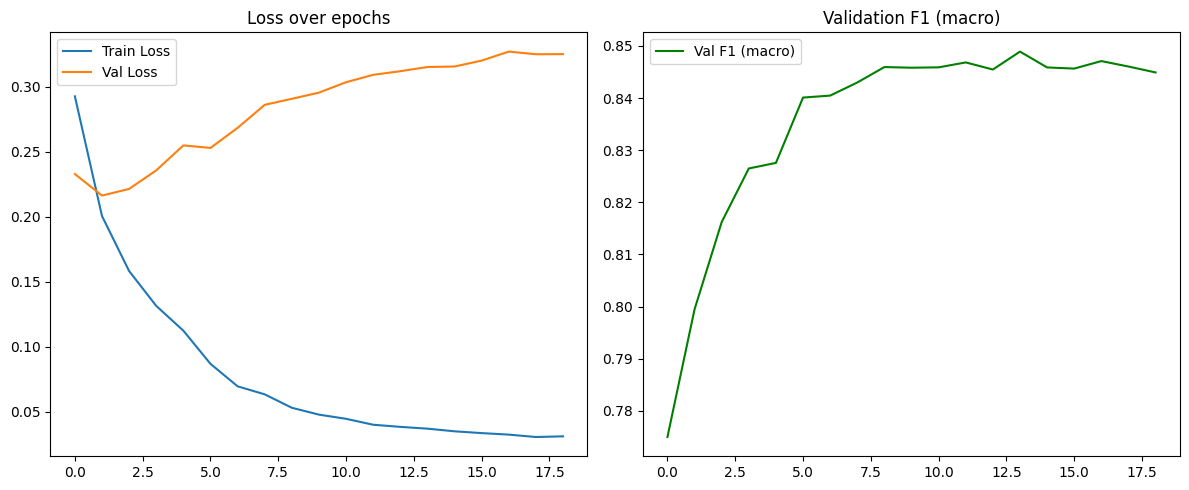

2025-05-18 11:53:42,406 - INFO - Best Validation F1 (macro): 0.8489 with threshold: 0.25
2025-05-18 11:53:57,056 - INFO - Test predictions saved to ConvNeXt_3001_long.csv
2025-05-18 11:53:57,085 - INFO -       id                                   labels
0  29568  0 1 0 0 1 0 0 1 1 1 0 1 1 1 1 1 1 1 1 0
1  29569  0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 1
2  29570  0 1 0 0 1 0 0 1 0 1 0 0 1 1 1 0 1 1 1 0
3  29571  1 1 0 0 1 0 0 1 0 1 0 0 1 1 0 0 1 0 1 0
4  29572  1 0 0 0 1 0 0 0 1 0 0 0 1 1 1 1 1 0 0 1
2025-05-18 11:53:57,089 - INFO - Shape: (7392, 2)


In [ ]:
import argparse
import copy
import csv
import logging
import os
import re
import time
import random

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from torch.utils.data import DataLoader, Dataset
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from tqdm import tqdm
from torch.amp import autocast, GradScaler  # Новая API для AMP

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)



logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

nltk.download('stopwords', quiet=True)
STOP_WORDS = set(stopwords.words('russian'))
STEMMER = SnowballStemmer('russian')


def clean_text_tfidf(text: str) -> str:
    text = text.lower()
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = re.sub(r'\+?\d{1,3}[-.\s]?\(?\d{1,4}\)?[-.\s]?\d{1,4}[-.\s]?\d{1,4}', '', text).strip()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    words = text.split()
    words = [STEMMER.stem(word) for word in words if word not in STOP_WORDS]
    return ' '.join(words)


class TfidfDataset(Dataset):

    def __init__(self, X, y):
        self.X = torch.tensor(X.toarray(), dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32)

    def __len__(self) -> int:
        return len(self.X)

    def __getitem__(self, idx: int):
        return self.X[idx], self.y[idx]


class MLPClassifier(nn.Module):

    def __init__(self, input_dim: int, output_dim: int):
        super(MLPClassifier, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, output_dim)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)


def plot_metrics(train_losses, val_losses, val_f1s) -> None:

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.legend()
    plt.title("Loss over epochs")
    plt.subplot(1, 2, 2)
    plt.plot(val_f1s, label='Val F1 (macro)', color='green')
    plt.legend()
    plt.title("Validation F1 (macro)")
    plt.tight_layout()
    plt.show()


def train_model(model: nn.Module,
                train_loader: DataLoader,
                val_loader: DataLoader,
                criterion,
                optimizer,
                scheduler,
                num_epochs: int = 50,
                model_path: str = 'best_model.pt',
                early_stopping_patience: int = 5) -> (nn.Module, float):

    device = next(model.parameters()).device
    best_model_wts = copy.deepcopy(model.state_dict())
    best_f1 = 0.0
    best_threshold = 0.5  # Начальный порог
    patience_counter = 0

    train_losses, val_losses, val_f1s = [], [], []

    def get_best_threshold(predictions, labels):
        best_f1_score = 0.0
        best_thresh = 0.5
        for thresh in np.arange(0.1, 0.91, 0.01):
            preds_binarized = (predictions > thresh).astype(int)
            score = f1_score(labels, preds_binarized, average='macro')
            if score > best_f1_score:
                best_f1_score = score
                best_thresh = thresh
        return best_thresh, best_f1_score

    scaler = GradScaler() if device.type == 'cuda' else None

    for epoch in range(num_epochs):
        epoch_start = time.time()
        logging.info(f'Epoch {epoch+1}/{num_epochs}')
        model.train()
        running_loss = 0.0

        for inputs, targets in tqdm(train_loader, desc="Training", leave=False):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            if scaler:
                # Используем autocast с параметром "cuda"
                with autocast("cuda"):
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()
            running_loss += loss.item()

        train_loss_epoch = running_loss / len(train_loader)
        train_losses.append(train_loss_epoch)

        model.eval()
        val_loss = 0.0
        all_preds, all_labels = [], []
        with torch.no_grad():
            for inputs, targets in tqdm(val_loader, desc="Validation", leave=False):
                inputs, targets = inputs.to(device), targets.to(device)
                if scaler:
                    with autocast("cuda"):
                        outputs = model(inputs)
                else:
                    outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
                # Применяем Sigmoid для получения вероятностей
                all_preds.append(torch.sigmoid(outputs).cpu().numpy())
                all_labels.append(targets.cpu().numpy())
        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        all_preds = np.vstack(all_preds)
        all_labels = np.vstack(all_labels)
        epoch_threshold, epoch_f1 = get_best_threshold(all_preds, all_labels)
        val_f1s.append(epoch_f1)
        current_lr = optimizer.param_groups[0]['lr']
        logging.info(f"Train Loss: {train_loss_epoch:.4f} | Val Loss: {val_loss:.4f} | "
                     f"Val F1 (macro): {epoch_f1:.4f} | Best Threshold: {epoch_threshold:.2f} | LR: {current_lr:.6f}")

        if scheduler is not None:
            scheduler.step(val_loss)

        if epoch_f1 > best_f1:
            best_f1 = epoch_f1
            best_threshold = epoch_threshold
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save({'model_state_dict': model.state_dict(), 'threshold': best_threshold}, model_path)
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                logging.info("No improvement observed, early stopping triggered.")
                break

        elapsed = time.time() - epoch_start
        logging.info(f"Epoch completed in {elapsed:.2f} seconds.")

    plot_metrics(train_losses, val_losses, val_f1s)
    logging.info(f"Best Validation F1 (macro): {best_f1:.4f} with threshold: {best_threshold:.2f}")
    model.load_state_dict(best_model_wts)
    return model, best_threshold


def predict_and_save(model: nn.Module,
                     tfidf_vectorizer: TfidfVectorizer,
                     test_df: pd.DataFrame,
                     best_threshold: float,
                     output_file: str = "ConvNeXt_2306_long.csv") -> None:

    device = next(model.parameters()).device
    test_df['text_tfidf'] = test_df['text'].apply(clean_text_tfidf)
    X_test = tfidf_vectorizer.transform(test_df['text_tfidf'])
    model.eval()
    with torch.no_grad():
        X_test_tensor = torch.tensor(X_test.toarray(), dtype=torch.float32).to(device)
        outputs_test = model(X_test_tensor)
        probs = torch.sigmoid(outputs_test)
        preds_test = (probs > best_threshold).float().cpu().numpy()

    results = []
    for idx, preds in zip(test_df['id'], preds_test):
        pred_str = " ".join(str(int(x)) for x in preds)
        results.append((idx, pred_str))

    with open(output_file, 'w', newline='', encoding='utf-8') as f:
        writer = csv.writer(f)
        writer.writerow(["ID", "labels"])
        writer.writerows(results)
    logging.info(f"Test predictions saved to {output_file}")

    # Сортировка по ID и вывод первых строк
    with open(output_file, 'r', newline='', encoding='utf-8') as f:
        reader = csv.reader(f)
        header = next(reader)
        header = [h.lower() if h.lower() in ['id', 'labels'] else h for h in header]
        rows = [[row[0].split('.')[0]] + row[1:] for row in reader]
    sorted_rows = sorted(rows, key=lambda x: int(x[0]))
    with open(output_file, 'w', newline='', encoding='utf-8') as f:
        writer = csv.writer(f)
        writer.writerow(header)
        writer.writerows(sorted_rows)
    data = pd.read_csv(output_file)
    logging.info(data.head())
    logging.info(f"Shape: {data.shape}")


def load_and_preprocess_data(train_file: str):

    if not os.path.exists(train_file):
        raise FileNotFoundError(f"Train file {train_file} not found!")
    df = pd.read_csv(train_file, encoding='utf-8')
    df.drop_duplicates(subset=['text', 'labels'], inplace=True)
    df['label_vector'] = df['labels'].apply(lambda x: list(map(int, x.strip().split())))
    df['text_tfidf'] = df['text'].apply(clean_text_tfidf)
    target_columns = [f'label_{i}' for i in range(len(df['label_vector'].iloc[0]))]
    df[target_columns] = pd.DataFrame(df['label_vector'].tolist(), index=df.index)
    return df, target_columns


def main(args):

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    logging.info(f"Using device: {device}")

    df, target_columns = load_and_preprocess_data(args.train_file)
    tfidf_vectorizer = TfidfVectorizer(max_features=args.max_features)
    X_tfidf = tfidf_vectorizer.fit_transform(df['text_tfidf'])
    y = df[target_columns]

    X_train, X_val, y_train, y_val = train_test_split(X_tfidf, y, test_size=0.2, random_state=SEED)
    train_dataset = TfidfDataset(X_train, y_train)
    val_dataset = TfidfDataset(X_val, y_val)
    train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=args.batch_size, shuffle=False)

    model = MLPClassifier(X_tfidf.shape[1], y.shape[1]).to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

    model, best_threshold = train_model(model, train_loader, val_loader, criterion,
                                        optimizer, scheduler=scheduler,
                                        num_epochs=args.epochs, model_path=args.model_path,
                                        early_stopping_patience=args.patience)

    if not os.path.exists(args.test_file):
        raise FileNotFoundError(f"Test file {args.test_file} not found!")
    test_df = pd.read_csv(args.test_file, encoding='utf-8')
    predict_and_save(model, tfidf_vectorizer, test_df, best_threshold, output_file=args.output_file)


if __name__ == "__main__":
    parser = argparse.ArgumentParser(description="Multilabel text classification training pipeline")
    parser.add_argument("--train_file", type=str, default="data_for_kaggle/train.csv", help="Path to training CSV file")
    parser.add_argument("--test_file", type=str, default="data_for_kaggle/test.csv", help="Path to test CSV file")
    parser.add_argument("--output_file", type=str, default="ConvNeXt_3001_long.csv", help="Output CSV file for predictions")
    parser.add_argument("--epochs", type=int, default=50, help="Number of training epochs")
    parser.add_argument("--batch_size", type=int, default=64, help="Batch size")
    parser.add_argument("--lr", type=float, default=1e-3, help="Learning rate")
    parser.add_argument("--max_features", type=int, default=10000, help="Max features for TfidfVectorizer")
    parser.add_argument("--model_path", type=str, default="mlp_tfidf_best.pt", help="Path to save the best model")
    parser.add_argument("--patience", type=int, default=5, help="Early stopping patience")
    args, unknown = parser.parse_known_args()
    main(args)


# **Красивый код, просто играюсь**

In [ ]:
#!/usr/bin/env python3
import argparse
import csv
import logging
import os
import re
from pathlib import Path
import random
from typing import Tuple, List

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint, LearningRateMonitor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
nltk.download('stopwords', quiet=True)
STOP_WORDS = set(stopwords.words('russian'))
STEMMER = SnowballStemmer('russian')


def clean_text_tfidf(text: str) -> str:
    text = text.lower()
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = re.sub(r'\+?\d{1,3}[-.\s]?\(?\d{1,4}\)?[-.\s]?\d{1,4}[-.\s]?\d{1,4}', '', text).strip()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    words = text.split()
    words = [STEMMER.stem(word) for word in words if word not in STOP_WORDS]
    return ' '.join(words)


class TfidfDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X.toarray(), dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32)

    def __len__(self) -> int:
        return len(self.X)

    def __getitem__(self, idx: int):
        return self.X[idx], self.y[idx]


class MLPClassifier(nn.Module):
    def __init__(self, input_dim: int, output_dim: int):
        super(MLPClassifier, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, output_dim)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)


class LitMLPClassifier(pl.LightningModule):

    def __init__(self, input_dim: int, output_dim: int, lr: float = 1e-3):
        super().__init__()
        self.save_hyperparameters()
        self.model = MLPClassifier(input_dim, output_dim)
        self.criterion = nn.BCEWithLogitsLoss()
        self.best_threshold = 0.5  # Оптимальный порог для F1
        self.validation_outputs = []  # Накопленные результаты валидационных батчей

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        self.log('train_loss', loss, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        preds = torch.sigmoid(logits)
        self.validation_outputs.append({
            'val_loss': loss.detach().cpu().item(),
            'preds': preds.detach().cpu().numpy(),
            'targets': y.detach().cpu().numpy()
        })
        return loss

    def on_validation_epoch_start(self):
        self.validation_outputs = []

    def on_validation_epoch_end(self):
        outputs = self.validation_outputs
        if len(outputs) == 0:
            return
        avg_loss = np.mean([o['val_loss'] for o in outputs])
        preds = np.concatenate([o['preds'] for o in outputs], axis=0)
        targets = np.concatenate([o['targets'] for o in outputs], axis=0)
        best_thresh, best_f1 = self._compute_best_threshold(preds, targets)
        self.log('val_loss', avg_loss, prog_bar=True)
        self.log('val_f1', best_f1, prog_bar=True)
        self.best_threshold = best_thresh

    def _compute_best_threshold(self, preds: np.ndarray, targets: np.ndarray) -> Tuple[float, float]:
        best_f1 = 0.0
        best_thresh = 0.5
        for thresh in np.arange(0.1, 0.91, 0.01):
            preds_bin = (preds > thresh).astype(int)
            score = f1_score(targets, preds_bin, average='macro')
            if score > best_f1:
                best_f1 = score
                best_thresh = thresh
        return best_thresh, best_f1

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                               mode='min',
                                                               factor=0.5,
                                                               patience=2)
        return {"optimizer": optimizer,
                "lr_scheduler": {"scheduler": scheduler, "monitor": "val_loss"}}


class TfidfDataModule(pl.LightningDataModule):
    def __init__(self, train_file: Path, batch_size: int, max_features: int):
        super().__init__()
        self.train_file: Path = train_file
        self.batch_size = batch_size
        self.max_features = max_features

    def prepare_data(self):
        # Данные уже лежат на диске, дополнительная загрузка не требуется
        pass

    def setup(self, stage=None):
        df, target_columns = load_and_preprocess_data(self.train_file)
        self.tfidf_vectorizer = TfidfVectorizer(max_features=self.max_features)
        X_tfidf = self.tfidf_vectorizer.fit_transform(df['text_tfidf'])
        y = df[target_columns]
        X_train, X_val, y_train, y_val = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)
        self.train_dataset = TfidfDataset(X_train, y_train)
        self.val_dataset = TfidfDataset(X_val, y_val)
        self.input_dim = X_tfidf.shape[1]
        self.output_dim = y.shape[1]
        self.target_columns = target_columns

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False)


def load_and_preprocess_data(train_file: Path) -> Tuple[pd.DataFrame, List[str]]:

    if not train_file.exists():
        raise FileNotFoundError(f"Train file {train_file} not found!")
    df = pd.read_csv(train_file, encoding='utf-8')
    df.drop_duplicates(subset=['text', 'labels'], inplace=True)
    df['label_vector'] = df['labels'].apply(lambda x: [int(v) for v in x.strip().split()])
    df['text_tfidf'] = df['text'].apply(clean_text_tfidf)
    n_labels = len(df['label_vector'].iloc[0])
    target_columns = [f'label_{i}' for i in range(n_labels)]
    df[target_columns] = pd.DataFrame(df['label_vector'].tolist(), index=df.index)
    logging.info("Training data preprocessed successfully.")
    return df, target_columns


def predict_and_save(model: LitMLPClassifier, device: str, data_module: TfidfDataModule,
                     test_file: Path, output_file: Path) -> None:

    if not test_file.exists():
        raise FileNotFoundError(f"Test file {test_file} not found!")
    test_df = pd.read_csv(test_file, encoding='utf-8')
    test_df['text_tf_idf'] = test_df['text'].apply(clean_text_tfidf)
    X_test = data_module.tfidf_vectorizer.transform(test_df['text_tf_idf'])

    model.eval()
    model.to(torch.device(device))
    with torch.no_grad():
        X_test_tensor = torch.tensor(X_test.toarray(), dtype=torch.float32).to(torch.device(device))
        outputs_test = model(X_test_tensor)
        probs = torch.sigmoid(outputs_test)  
        preds_test = (probs > model.best_threshold).float().cpu().numpy()

    results = []
    if 'id' in test_df.columns:
        id_values = test_df['id']
    else:
        id_values = test_df.index.astype(str)

    for idx, preds in zip(id_values, preds_test):
        pred_str = " ".join(str(int(x)) for x in preds)
        results.append((idx, pred_str))

    with output_file.open('w', newline='', encoding='utf-8') as f:
        writer = csv.writer(f)
        writer.writerow(["ID", "labels"])
        writer.writerows(results)
    logging.info(f"Raw test predictions saved to {output_file}")

    with output_file.open('r', newline='', encoding='utf-8') as f:
        reader = csv.reader(f)
        header = next(reader)
        header = [h.lower() if h.lower() in ['id', 'labels'] else h for h in header]
        rows = [[row[0].split('.')[0]] + row[1:] for row in reader]

    sorted_rows = sorted(rows, key=lambda x: int(x[0]))
    with output_file.open('w', newline='', encoding='utf-8') as f:
        writer = csv.writer(f)
        writer.writerow(header)
        writer.writerows(sorted_rows)

    data = pd.read_csv(output_file)
    logging.info(f"Final test predictions (first 5 rows):\n{data.head()}")
    logging.info(f"Test predictions shape: {data.shape}")


def main(args):
    pl.seed_everything(args.seed, workers=True)
    device = "cuda" if torch.cuda.is_available() and args.use_gpu else "cpu"
    logging.info(f"Using device: {device}")

    train_path = Path(args.train_file)
    test_path = Path(args.test_file)
    output_path = Path(args.output_file)

    data_module = TfidfDataModule(train_file=train_path,
                                  batch_size=args.batch_size,
                                  max_features=args.max_features)
    data_module.setup()

    input_dim = data_module.input_dim
    output_dim = data_module.output_dim

    model = LitMLPClassifier(input_dim=input_dim, output_dim=output_dim, lr=args.lr)
    early_stop_callback = EarlyStopping(
        monitor="val_f1", mode="max", patience=args.patience, verbose=True
    )
    checkpoint_callback = ModelCheckpoint(
        monitor="val_f1", mode="max", filename="best-checkpoint", save_top_k=1
    )
    lr_monitor = LearningRateMonitor(logging_interval="epoch")

    trainer = pl.Trainer(
        max_epochs=args.epochs,
        accelerator="gpu" if device == "cuda" else "cpu",
        devices=1,
        callbacks=[early_stop_callback, checkpoint_callback, lr_monitor],
        log_every_n_steps=10
    )

    logging.info("Starting training ...")
    trainer.fit(model, datamodule=data_module)
    best_model = LitMLPClassifier.load_from_checkpoint(checkpoint_callback.best_model_path)
    best_threshold = best_model.best_threshold
    logging.info(f"Best validation threshold determined: {best_threshold}")
    predict_and_save(best_model, device, data_module, test_path, output_path)


if __name__ == "__main__":
    parser = argparse.ArgumentParser(
        description="Multilabel text classification training pipeline (PyTorch Lightning)"
    )
    parser.add_argument("--train_file", type=str, default="data_for_kaggle/train.csv",
                        help="Path to training CSV file")
    parser.add_argument("--test_file", type=str, default="data_for_kaggle/test.csv",
                        help="Path to test CSV file")
    parser.add_argument("--output_file", type=str, default="predictions8.csv",
                        help="Output CSV file for predictions")
    parser.add_argument("--epochs", type=int, default=50,
                        help="Number of training epochs")
    parser.add_argument("--batch_size", type=int, default=64,
                        help="Batch size")
    parser.add_argument("--lr", type=float, default=1e-3,
                        help="Learning rate")
    parser.add_argument("--max_features", type=int, default=10000,
                        help="Max features for TfidfVectorizer")
    parser.add_argument("--patience", type=int, default=5,
                        help="Early stopping patience")
    parser.add_argument("--seed", type=int, default=42,
                        help="Random seed for reproducibility")
    parser.add_argument("--use_gpu", action="store_true",
                        help="Use GPU if available")

    args, _ = parser.parse_known_args()
    main(args)


Epoch 8: 100%|██████████| 344/344 [00:17<00:00, 20.11it/s, v_num=7, train_loss_step=0.201, val_loss=0.283, val_f1=0.843, train_loss_epoch=0.0637] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 344/344 [00:20<00:00, 16.93it/s, v_num=7, train_loss_step=0.201, val_loss=0.285, val_f1=0.847, train_loss_epoch=0.0543]

2025-05-18 11:08:06,377 - INFO - Metric val_f1 improved by 0.000 >= min_delta = 0.0. New best score: 0.847


Epoch 9: 100%|██████████| 344/344 [00:17<00:00, 20.20it/s, v_num=7, train_loss_step=0.129, val_loss=0.285, val_f1=0.847, train_loss_epoch=0.0543] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 344/344 [00:17<00:00, 19.99it/s, v_num=7, train_loss_step=0.0777, val_loss=0.295, val_f1=0.846, train_loss_epoch=0.048]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 344/344 [00:17<00:00, 20.15it/s, v_num=7, train_loss_step=0.234, val_loss=0.300, val_f1=0.844, train_loss_epoch=0.0448] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 344/344 [00:20<00:00, 17.05it/s, v_num=7, train_loss_step=0.234, val_loss=0.308, val_f1=0.849, train_loss_epoch=0.0408]

2025-05-18 11:09:16,144 - INFO - Metric val_f1 improved by 0.002 >= min_delta = 0.0. New best score: 0.849


Epoch 12: 100%|██████████| 344/344 [00:17<00:00, 20.20it/s, v_num=7, train_loss_step=0.120, val_loss=0.308, val_f1=0.849, train_loss_epoch=0.0408] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|██████████| 344/344 [00:17<00:00, 19.99it/s, v_num=7, train_loss_step=0.124, val_loss=0.312, val_f1=0.848, train_loss_epoch=0.0384] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 14: 100%|██████████| 344/344 [00:17<00:00, 19.81it/s, v_num=7, train_loss_step=0.0548, val_loss=0.314, val_f1=0.846, train_loss_epoch=0.0365]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 15: 100%|██████████| 344/344 [00:17<00:00, 19.86it/s, v_num=7, train_loss_step=0.110, val_loss=0.315, val_f1=0.846, train_loss_epoch=0.0342] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 15: 100%|██████████| 344/344 [00:20<00:00, 16.78it/s, v_num=7, train_loss_step=0.110, val_loss=0.321, val_f1=0.850, train_loss_epoch=0.0335]

2025-05-18 11:10:46,875 - INFO - Metric val_f1 improved by 0.001 >= min_delta = 0.0. New best score: 0.850


Epoch 16: 100%|██████████| 344/344 [00:17<00:00, 19.79it/s, v_num=7, train_loss_step=0.109, val_loss=0.321, val_f1=0.850, train_loss_epoch=0.0335] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 17: 100%|██████████| 344/344 [00:17<00:00, 20.23it/s, v_num=7, train_loss_step=0.079, val_loss=0.324, val_f1=0.850, train_loss_epoch=0.0327] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 18: 100%|██████████| 344/344 [00:17<00:00, 20.14it/s, v_num=7, train_loss_step=0.0704, val_loss=0.321, val_f1=0.850, train_loss_epoch=0.0314]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 18: 100%|██████████| 344/344 [00:20<00:00, 17.01it/s, v_num=7, train_loss_step=0.0704, val_loss=0.330, val_f1=0.852, train_loss_epoch=0.0308]

2025-05-18 11:11:56,774 - INFO - Metric val_f1 improved by 0.001 >= min_delta = 0.0. New best score: 0.852


Epoch 19: 100%|██████████| 344/344 [00:17<00:00, 19.94it/s, v_num=7, train_loss_step=0.178, val_loss=0.330, val_f1=0.852, train_loss_epoch=0.0308] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 20: 100%|██████████| 344/344 [00:17<00:00, 19.92it/s, v_num=7, train_loss_step=0.0311, val_loss=0.328, val_f1=0.845, train_loss_epoch=0.0304]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 86/86 [00:01<00:00, 73.74it/s]